# Оптимизация производственных расходов на металлургическом комбинате. Прогнозирование температуры сплава

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Задача проекта — построить модель, которая будет её предсказывать. Готовая модель будет использоваться для имитации технологического процесса
<br>

---

**Цель исследования:** построить модель, которая будет предсказывать конечную температуру сплава

---

**План выполнения работы:**

- загрузка и предварительное изучение данных
- исследовательский анализ и предобработка каждой таблицы по отдельности 
- выбор и создание новых признаков для обучения моделей
- объединение данных
- исследовательский анализ данных в объединённой таблице
- корреляционный анализ данных
- подготовка данных к обучению
- обучение моделей
- выбор лучшей модели
- анализ важности признаков
    
Каждый шаг исследования заканчивается промежуточным выводом. В конце исследования даётся общий подробный вывод

---

- во всех файлах столбец `key` содержит номер партии
- в файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки
- итоговая метрика MAE получившейся модели должна быть меньше или равна 6.8

---

In [1]:
# установка широкоформатного jupyter

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# установка модулей

!pip install phik -q
!pip install xgboost -q

In [3]:
# импорт библиотек

import os
import re
import copy
import warnings
from time import time
from IPython.display import display
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import phik
from scipy.stats import uniform, randint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from catboost.utils import eval_metric
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
# константы

RANDOM_STATE = 40624
TEST_SIZE = 0.25
TARGET = 'last_temp'

DATA_ARC_NEW = 'D:\\datasets\\final_project\\data_arc_new.csv'
DATA_BULK_NEW = 'D:\\datasets\\final_project\\data_bulk_new.csv'
DATA_BULK_TIME_NEW = 'D:\\datasets\\final_project\\data_bulk_time_new.csv'
DATA_GAS_NEW = 'D:\\datasets\\final_project\\data_gas_new.csv'
DATA_TEMP_NEW = 'D:\\datasets\\final_project\\data_temp_new.csv'
DATA_WIRE_NEW = 'D:\\datasets\\final_project\\data_wire_new.csv'
DATA_WIRE_TIME_NEW = 'D:\\datasets\\final_project\\data_wire_time_new.csv'

PATHS = [DATA_ARC_NEW, DATA_BULK_NEW, DATA_BULK_TIME_NEW, DATA_GAS_NEW, DATA_TEMP_NEW, DATA_WIRE_NEW, DATA_WIRE_TIME_NEW]
NAMES = ['arc', 'bulk', 'bulk_time', 'gas', 'temp', 'wire', 'wire_time']

---

In [5]:
def get_info(data):
    
    """
    Функция get_info выводит на экран пять случайных строк таблицы и общую информацию, полученную с помощью info()

    Аргументы:
    data (DataFrame): датафрейм

    """
    
    print('Пять случайных строк таблицы:')
    display(data.sample(5))
    print(' ')
    print('Общая информация о таблице:')
    print(' ')
    print(data.info())

In [6]:
def preprocess(data, data_name):
    
    """
    Функция preprocess выводит на экран количество дубликатов и пропусков в датафрейме

    Аргументы:
    data (DataFrame) : датафрейм
    data_name (str) : название датафрейма
    
    """
    
    for col in data:
        isna_count = data[col].isna().sum()
        if isna_count > 0:
            print(f'Пропусков найдено в столбце {col}: {isna_count}')
    isna_total = data.isna().sum().sum()
    if isna_total == 0:
        print(f'В таблице {data_name} не найдено ни одного пропуска!')
        
    duplicates_count = data.duplicated().sum()
    if duplicates_count > 0:
        print(f'Дубликатов найдено: {duplicates_count}')
    else:
        print(f'В таблице {data_name} не найдено ни одного дубликата!')

In [7]:
def isna_share(data, file_name):
    
    """
    Функция isna_share подсчитывает и выводит на экран долю пропущенных значений 
    
    Аргументы:
    data (DataFrame) : датафрейм
    file_name (str) : название таблицы
    
    """
    
    print(f'Доля пропущенных значений в файле {file_name}:')
    print(' ')
    print(data.apply(lambda x: f"{100 - (x.count() / len(x)) * 100:.2f}%"))

In [8]:
def describe(data, col, data_name):
                    
    """
    Функция describe выводит на экран числовое описание данных в количественном столбце

    Аргументы:
    data (DataFrame) : датафрейм
    col (str) : столбец датафрейма
    data_name (str) : название датафрейма
    
    """
    
    print(f'Числовое описание столбца {col} таблицы {data_name}:')
    print(' ')
    print(data[col].describe())

In [9]:
def hist_violin(data, col, bins, xlabel, title, figsize=(16, 4)):
                        
    """
    Функция hist_violin выводит на экран гистограмму и скрипичную диаграмму

    Аргументы:
    data (DataFrame) : датафрейм
    col (str) : столбец датафрейма
    bins (int) : количество корзин для гистограммы
    xlabel (str) : подпись оси X
    title (str) : заголовок
    figsize : размер графика (по умолчанию 16x4)
    
    """
    
    sns.set(style='darkgrid', palette='pastel')
    fig, ax = plt.subplots(1, 2, figsize=figsize)

    sns.histplot(data=data, x=col, kde=True, bins=bins, color='#abc9eb')
    plt.title('Гистограмма', fontsize=14)
    plt.ylabel('Количество значений', fontsize=11)
    plt.xlabel(xlabel, fontsize=11)
    ax[0].grid()
    
    sns.violinplot(x=data[col], ax=ax[0], color='#abc9eb')
    ax[0].set_title('Скрипичная диаграмма', fontsize=14)
    ax[0].set_ylabel('Количество значений', fontsize=11)
    ax[0].set_xlabel(xlabel, fontsize=11)
    ax[0].grid()
    
    ax_title = fig.add_axes([0.5, 1.0, 0.1, 0.1])
    ax_title.set_axis_off()
    ax_title.text(0, 0, title, ha='center', va='center', fontsize=18)

    plt.show()

In [10]:
def barplot(data, col, xlabel, ylabel, title, figsize=(8, 4.5), normalize=False):
    
    """
    Функция barplot выводит на экран столбчатую диаграмму
    
    Аргументы:
    data (DataFrame) : датафрейм
    col (str) : столбец датафрейма
    xlabel (str) : подпись оси Х
    ylabel (str) : подпись оси Y
    title (str) : заголовок
    figsize : размер графика (по умолчанию 8x4.5)
    normalize (bool) : True/False (по умолчанию False)
    
    """
    
    sns.set(style='darkgrid', palette='pastel')
    plt.figure(figsize=figsize)
    
    data_new = data[col].value_counts(normalize=normalize)
    data_new_ = data_new.reset_index()
    data_new_.columns = [col, 'count']
    
    ax = sns.barplot(x=col, y='count', data=data_new_, color='#abc9eb')
    for p in ax.patches:
        if normalize:
            ax.text(p.get_x() + p.get_width() / 2., p.get_height(), 
                    f'{int(p.get_height() * 100)}%', 
                    ha='center', va='bottom', fontsize=8)
        else:
            ax.text(p.get_x() + p.get_width() / 2., p.get_height(), 
                    f'{int(p.get_height())}', 
                    ha='center', va='bottom', fontsize=8)
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    
    plt.tight_layout()
    plt.show()

In [11]:
def barplot_no_y(data, col, xlabel, title, figsize=(8, 4.5), normalize=False):
    
    """
    Функция barplot_no_y выводит на экран столбчатую диаграмму
    БЕЗ подписей оси Y
    
    Аргументы:
    data (DataFrame) : датафрейм
    col (str) : столбец датафрейма
    xlabel (str) : подпись оси Х
    title (str) : заголовок
    figsize : размер графика (по умолчанию 8x4.5)  
    normalize (bool) : True/False (по умолчанию False)
    
    """
    
    sns.set(style='darkgrid', palette='pastel')
    plt.figure(figsize=figsize)
    
    data_new = data[col].value_counts(normalize=normalize)
    data_new_ = data_new.reset_index()
    data_new_.columns = [col, 'count']
    
    ax = sns.barplot(x=col, y='count', data=data_new_, color='#abc9eb')
    for p in ax.patches:
        if normalize:
            ax.text(p.get_x() + p.get_width() / 2., p.get_height(), 
                    f'{int(p.get_height() * 100)}%', 
                    ha='center', va='bottom', fontsize=8)
        else:
            ax.text(p.get_x() + p.get_width() / 2., p.get_height(), 
                    f'{int(p.get_height())}', 
                    ha='center', va='bottom', fontsize=8)
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_ylabel(' ', fontsize=11)
    ax.set_yticklabels([])
    
    plt.tight_layout()
    plt.show()

In [12]:
def barh_pivot(data, xlabel, ylabel, title, figsize=(9.3, 4)):

    """
    Функция barh_pivot выводит на экран горизонтальную столбчатую диаграмму

    Аргументы:
    data (DataFrame) : датафрейм, содержащий сводную таблицу
    xlabel (str) : подпись оси X
    ylabel (str) : подпись оси Y
    title (str) : заголовок
    figsize : размер графика (по умолчанию )
    
    """
    
    ax = data.plot(kind='barh', figsize=figsize, color='#abc9eb', grid=True, legend=False)
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.invert_yaxis()
    
    for i in ax.patches:
        ax.text(i.get_width(), i.get_y() + i.get_height() / 2, f'{i.get_width():.0f}', 
                fontsize=8, color='black', ha='left', va='center')
    
    plt.show()

In [13]:
def find_high_correlation(data, corr_threshold=0.9):
    
    """
    Функция find_high_correlation создаёт матрицу корреляции с помощью метода corr(),
    проходит про ней циклом и записывает в переменную corr_pairs такие пары столбцов,
    коэффициент корреляции которых составляет 0.9 или более
    
    Аргументы:
    data (DataFrame): датафрейм
    corr_threshold (не требует ввода) : 0.9
    
    """
    
    corr_matrix = data.corr()
    corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= corr_threshold:
                corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))
                
    return corr_pairs

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Загрузка и предварительное изучение данных. Исследовательский анализ и предобработка каждой таблицы
</div>

---

In [14]:
def load_datasets():
    
    """
    Функция load_datasets загружает csv-файлы, пути к которым хранятся в переменной PATHS
    
    Возвращает:
    datasets (list) : список, содержащий в себе все загруженные таблицы
    
    """
    
    datasets = []

    for path in PATHS:
        try:
            data = pd.read_csv(path, sep=',')
            filename = os.path.basename(path)
            print(f'Файл {filename} успешно загружен!')
            datasets.append(data)
        except Exception as error:
            print(f'Упс, что-то пошло не так при загрузке файла {os.path.basename(path)}! Текст ошибки: {repr(error)}')

    return datasets

In [15]:
# применим функцию load_datasets()

datasets = load_datasets()

Файл data_arc_new.csv успешно загружен!
Файл data_bulk_new.csv успешно загружен!
Файл data_bulk_time_new.csv успешно загружен!
Файл data_gas_new.csv успешно загружен!
Файл data_temp_new.csv успешно загружен!
Файл data_wire_new.csv успешно загружен!
Файл data_wire_time_new.csv успешно загружен!


In [16]:
# сохраним таблицы в переменные с соответствующими им именами

for name, dataset in zip(NAMES, datasets):
    globals()[name] = dataset

---

### `data_arc_new.csv`

In [17]:
# изучим общую информацию о таблице

get_info(arc)

Пять случайных строк таблицы:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
11156,2429,2019-08-07 22:50:25,2019-08-07 22:55:40,0.615012,0.456947
14593,3174,2019-09-04 08:53:52,2019-09-04 08:55:36,0.617912,0.424270
4973,1073,2019-06-13 17:19:56,2019-06-13 17:23:05,0.697737,0.580026
12200,2650,2019-08-16 07:58:14,2019-08-16 07:59:49,0.810875,0.632907
13190,2868,2019-08-24 07:15:11,2019-08-24 07:17:23,0.546057,0.385944


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None


- таблица `data_arc_new` содержит 14876 строк и 5 столбцов
- названия столбцов требуют переименования
- в таблице нет пропусков
- типы данных определены верно во всех столбцах, кроме `Начало нагрева дугой` и `Конец нагрева дугой`
- данные соответствуют описанию

---

In [18]:
# переименуем столбцы

arc_new_cols = ['key', 'heating_start', 'heating_end', 'active_power', 'reactive_power']
arc.columns = arc_new_cols

# проверим результат

print('Обновлённый список столбцов:', arc.columns.to_list())

Обновлённый список столбцов: ['key', 'heating_start', 'heating_end', 'active_power', 'reactive_power']


In [19]:
# проверим таблицу на наличие пропусков и дубликатов

preprocess(arc, 'arc')

В таблице arc не найдено ни одного пропуска!
В таблице arc не найдено ни одного дубликата!


In [20]:
# приведём столбцы с временными рядами к соответствующему типу данных

arc['heating_start'] = pd.to_datetime(arc['heating_start'], format='%Y-%m-%d %H:%M:%S')
arc['heating_end'] = pd.to_datetime(arc['heating_end'], format='%Y-%m-%d %H:%M:%S')

---

In [21]:
# посмотрим на числовое описание столбцов active_power и reactive_power

describe(arc, 'active_power', 'arc')
print(' ')
describe(arc, 'reactive_power', 'arc')

Числовое описание столбца active_power таблицы arc:
 
count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: active_power, dtype: float64
 
Числовое описание столбца reactive_power таблицы arc:
 
count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: reactive_power, dtype: float64


Судя по числовому описанию столбца `active_power`, данные об активной мощности достаточно равномерные и реалистичные. Минимальное значение составило 0.223120, максимальное — 1.463773, средним же значением является 0.662752, а по медиане — 0.599587. 

В столбце `reactive_power` явно что-то не так, стандартное отклонение очень большое для имеющихся значений и минимальное значение слишком выбивается из общей картины, искажая общую статистику. Попробуем посмотреть, сколько вообще в таблице строк с отрицательной реактивной мощностью

In [22]:
# оценим количество наблюдений, в которых реактивная мощность является отрицательной

arc.query('reactive_power < 0')

,key,heating_start,heating_end,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Лишь в одной строке реактивная мощность опустилась ниже нуля, и это произошло в партии под номером 2116. Если взглянуть на то, как различаются между собой значения активной и реактивной мощностей, можно увидеть, что они записаны в одной единице измерения. Если в этой строке активная мощность составила 0.705344, то в записи реактивной мощности, предположительно, возникла ошибка, и на самом деле она могла бы быть равна 0.715479. Однако мы также видим, что реактивная мощность не может быть выше активной. Если бы таких строк было много, то необходимо было бы найти решение по исправлению этой ошибки, но так как строка всего одна, то мы просто оставим её, как есть, а для визуализации графиков сформируем срез

In [23]:
# сформируем срез данных и запишем его в переменную arc_query

arc_query = arc.query('reactive_power > 0')

In [24]:
# снова посмотрим на числовое описание данных в столбце reactive_power

describe(arc_query, 'reactive_power', 'arc_query')

Числовое описание столбца reactive_power таблицы arc_query:
 
count    14875.000000
mean         0.487115
std          0.197612
min          0.153777
25%          0.337190
50%          0.441665
75%          0.608223
max          1.270284
Name: reactive_power, dtype: float64


Теперь минимальное занчение реактивной мощности составляет 0.153777, максимальное — 1.270284, среднее — 0.487115 и по медиане — 0.441665

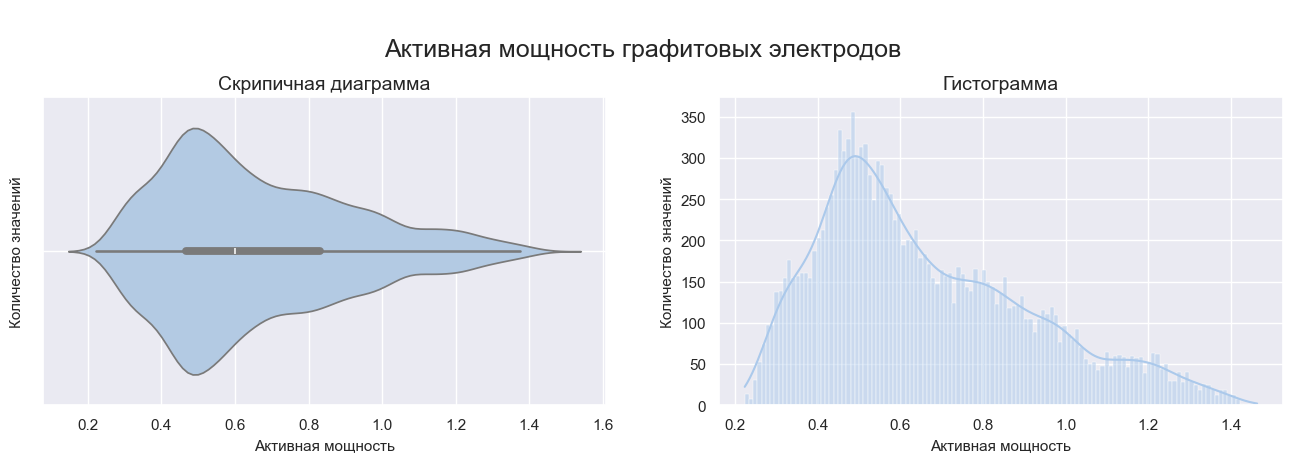

In [25]:
# выведем на экран гистограмму и скрипичную диаграмму для столбца active_power

hist_violin(arc_query, 'active_power', 121, 'Активная мощность', 'Активная мощность графитовых электродов')

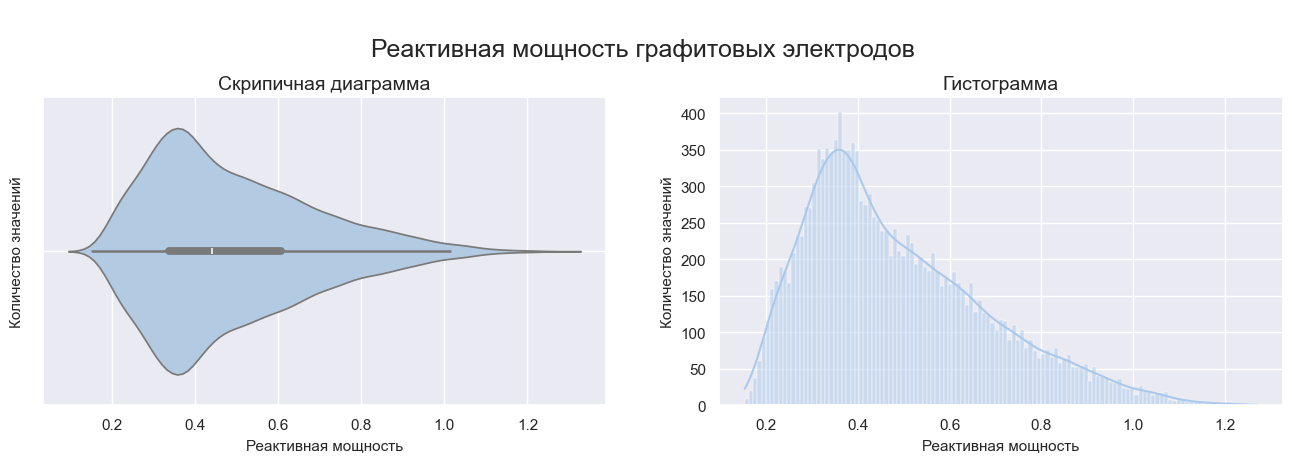

In [26]:
# выведем на экран гистограмму и скрипичную диаграмму для столбца reactive_power

hist_violin(arc_query, 'reactive_power', 121, 'Реактивная мощность', 'Реактивная мощность графитовых электродов')

На графиках видим то же, что и в числовом описании этих признаков — реактивная мощность немного ниже активной. В процессе электродуговой плавки активная мощность обычно действительно выше реактивной мощности, и это связано с тем, что активная мощность отражает реальную работу, выполняемую электродами для нагрева и плавления металла, в то время как реактивная мощность связана с созданием магнитных полей, которые необходимы для работы электродуговой печи, но не приводят к непосредственному нагреву металла. Это указывает на то, что большая часть энергии используется для выполнения полезной работы (нагрева), а не тратится на создание магнитных полей. Это хороший признак эффективности процесса плавки.

На всех графиках мы видим, что основное количество значений сосредоточено в диапазоне от 0.2 до 0.6. Нельзя сделать какой-то однозначный вывод о диапазоне значений на этих графиках, потому что нет возможности уточнить у заказчика данные, касающиеся модели печи — именно эта информация помогла бы определить точные верхние и нижние границы мощности, однако можно сказать, что обе мощности поднимаются выше 1.0 мВт-ч очень редко

In [27]:
# посмотрим, за какой период собраны данные

print(f"Данные о времени начала нагрева дугой собраны в период с {arc['heating_start'].min()} по {arc['heating_start'].max()}")
print(f"Данные о времени завершения нагрева дугой собраны в период с {arc['heating_end'].min()} по {arc['heating_end'].max()}")

Данные о времени начала нагрева дугой собраны в период с 2019-05-03 11:02:14 по 2019-09-06 17:24:54
Данные о времени завершения нагрева дугой собраны в период с 2019-05-03 11:06:02 по 2019-09-06 17:26:15


In [28]:
# посчитаем количество уникальных партий в данных

print(f"Количество партий: {arc['key'].nunique()}")

Количество партий: 3214


---

### `data_bulk_new.csv`

In [29]:
# изучим общую информацию о таблице

get_info(bulk)

Пять случайных строк таблицы:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1652,1712,NaN,NaN,NaN,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.0,NaN
1705,1765,NaN,NaN,158.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,NaN,99.0,205.0
1119,1167,NaN,NaN,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256.0,NaN,132.0,203.0
1761,1823,NaN,NaN,79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,253.0,NaN
2782,2887,30.0,NaN,78.0,NaN,NaN,66.0,NaN,NaN,NaN,NaN,NaN,416.0,NaN,254.0,104.0


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB
None


- таблица `data_bulk_new` содержит 3129 строк и 16 столбцов
- названия столбцов требуют переименования
- некоторые из столбцов содержат критическое количество пропусков, из-за чего они в целом, скорее всего, становятся бесполезными для работы
- пропуски есть во всех столбцах, кроме `key`
- типы данных определены неверно — знаков после запятой на самом деле быть не должно
- данные соответствуют описанию

---

In [30]:
# переименуем столбцы

bulk.columns = bulk.columns.str.replace(' ', '_').str.lower()

# проверим результат

print('Обновлённый список столбцов:', bulk.columns.to_list())

Обновлённый список столбцов: ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']


In [31]:
# проверим таблицу на наличие пропусков и дубликатов

print(f'Дубликатов найдено в таблице bulk: {bulk.duplicated().sum()}')

Дубликатов найдено в таблице bulk: 0


---

In [32]:
# посмотрим, какую долю составляют пропуски в этой таблице

isna_share(bulk, 'data_bulk_new')

Доля пропущенных значений в файле data_bulk_new:
 
key         0.00%
bulk_1     91.95%
bulk_2     99.30%
bulk_3     58.52%
bulk_4     67.59%
bulk_5     97.54%
bulk_6     81.59%
bulk_7     99.20%
bulk_8     99.97%
bulk_9     99.39%
bulk_10    94.38%
bulk_11    94.34%
bulk_12    21.70%
bulk_13    99.42%
bulk_14    10.32%
bulk_15    28.16%
dtype: object


Таблица содержит данные о подаче сыпучих материалов. Это значит, что в нашем случае пропуски равны отсутствию подачи сыпучего материала в партии. Отсутствие чего-то — тоже признак, поэтому заполним пропущенные значения нулями

In [33]:
# заменим пропущенные значения нулями и приведём данные в целочисленный тип

bulk = bulk.fillna(0).astype(int)

In [34]:
# снова проверим таблицу на наличие пропусков

preprocess(bulk, 'bulk')

В таблице bulk не найдено ни одного пропуска!
В таблице bulk не найдено ни одного дубликата!


---

In [35]:
# посмотрим на числовое описание всей таблицы

bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [36]:
def extract_number(col):
    
    """
    
    Функция extract_number извлекает числовую часть из названия столбца
    и возвращает ее как целое число
    
    """
    
    match = re.search(r'\d+', col)
    return int(match.group()) if match else None

In [37]:
# отсоортируем названия столбцов с помощью функции extract_number

sorted_columns = sorted(bulk.columns[1:], key=extract_number)

In [38]:
# сформируем сводную таблицу

bulk_pivot = bulk.pivot_table(index='key', values=sorted_columns, aggfunc='mean').mean()

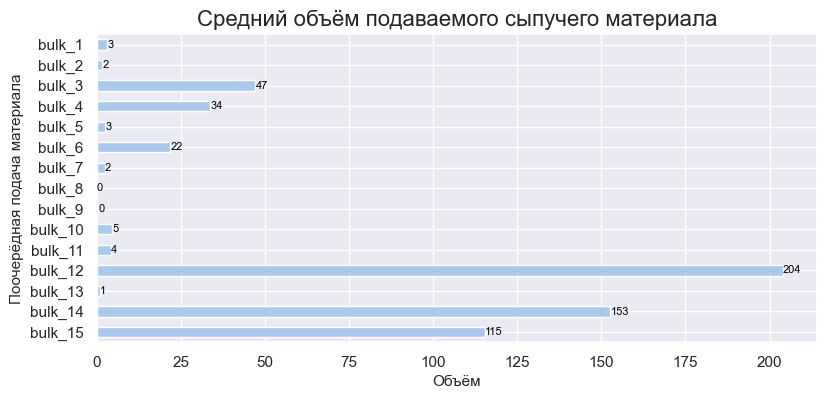

In [39]:
# построим столбчатую диаграмму

barh_pivot(bulk_pivot[sorted_columns], 'Объём', 'Поочерёдная подача материала', 'Средний объём подаваемого сыпучего материала')

Сыпучий материал подаётся в очень большом объёме не с самого начала, а только после двенадцатой подачи

---

### `data_bulk_time_new.csv`

In [40]:
# изучим общую информацию о таблице

get_info(bulk_time)

Пять случайных строк таблицы:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
535,564,NaN,NaN,NaN,2019-05-24 23:23:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-24 23:05:51,NaN,2019-05-24 23:23:10,2019-05-24 23:15:05
1558,1616,2019-07-03 01:08:30,NaN,2019-07-03 01:18:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-03 01:13:13,NaN,2019-07-03 01:08:30,2019-07-03 00:54:30
1338,1390,NaN,NaN,2019-06-24 21:00:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-24 21:12:06,NaN,2019-06-24 21:17:14,2019-06-24 21:12:06
334,359,NaN,NaN,NaN,2019-05-17 14:03:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-17 13:59:55,NaN,2019-05-17 13:54:08,2019-05-17 13:47:02
2430,2522,NaN,NaN,NaN,NaN,NaN,2019-08-11 07:31:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-11 07:22:02,NaN


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB
None


- таблица `data_bulk_time_new` содержит 3129 строк и 16 столбцов
- названия столбцов требуют переименования
- пропусков нет только в столбце `key`
- все остальные столбцы, скорее всего, содержат временные ряды
- данные соответствуют описанию

---

In [41]:
# переименуем столбцы

bulk_time.columns = bulk_time.columns.str.replace(' ', '_').str.lower()

# проверим результат

print('Обновлённый список столбцов:', bulk_time.columns.to_list())

Обновлённый список столбцов: ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']


In [42]:
# проверим таблицу на наличие дубликатов

print(f'Дубликатов найдено в таблице bulk_time: {bulk_time.duplicated().sum()}')

Дубликатов найдено в таблице bulk_time: 0


---

In [43]:
# посмотрим, какую долю составляют пропуски в этой таблице

isna_share(bulk_time, 'data_bulk_time_new')

Доля пропущенных значений в файле data_bulk_time_new:
 
key         0.00%
bulk_1     91.95%
bulk_2     99.30%
bulk_3     58.52%
bulk_4     67.59%
bulk_5     97.54%
bulk_6     81.59%
bulk_7     99.20%
bulk_8     99.97%
bulk_9     99.39%
bulk_10    94.38%
bulk_11    94.34%
bulk_12    21.70%
bulk_13    99.42%
bulk_14    10.32%
bulk_15    28.16%
dtype: object


Ожидаемо, в файлах `data_bulk_new` и `data_bulk_time_new` пропущенные значения аналогичны

In [44]:
# изменим тип данных с object на datetime

for i in range(1, 15+1):
    bulk_time[f'bulk_{i}'] = pd.to_datetime(bulk_time[f'bulk_{i}'], format='%Y-%m-%d %H:%M:%S')
    
# проверим результат

print('Обновлённый список типов данных в таблице data_bulk_time_new:')
print(' ')
print(bulk_time.dtypes)

Обновлённый список типов данных в таблице data_bulk_time_new:
 
key                 int64
bulk_1     datetime64[ns]
bulk_2     datetime64[ns]
bulk_3     datetime64[ns]
bulk_4     datetime64[ns]
bulk_5     datetime64[ns]
bulk_6     datetime64[ns]
bulk_7     datetime64[ns]
bulk_8     datetime64[ns]
bulk_9     datetime64[ns]
bulk_10    datetime64[ns]
bulk_11    datetime64[ns]
bulk_12    datetime64[ns]
bulk_13    datetime64[ns]
bulk_14    datetime64[ns]
bulk_15    datetime64[ns]
dtype: object


In [45]:
# заменим пропущенные значения нулями

bulk_time = bulk_time.fillna(0)

# оценим результат

get_info(bulk_time)

Пять случайных строк таблицы:


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
1543,1601,0,0,2019-07-02 12:49:52,0,0,2019-07-02 13:08:19,0,0,0,0,0,0,0,0,0
1349,1401,0,0,2019-06-25 06:01:41,0,0,0,0,0,0,0,0,0,0,0,0
1592,1651,0,0,2019-07-04 02:31:25,0,0,0,0,0,0,0,0,2019-07-04 02:26:54,0,2019-07-04 02:24:20,2019-07-04 02:11:35
1413,1467,2019-06-27 17:30:37,0,0,2019-06-27 17:26:05,0,0,0,0,0,0,0,2019-06-27 17:19:45,0,2019-06-27 17:14:32,2019-06-27 17:09:56
1087,1135,0,0,0,0,0,0,0,0,0,0,2019-06-15 17:46:40,2019-06-15 17:43:17,0,2019-06-15 17:25:43,2019-06-15 17:18:24


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   3129 non-null   object
 2   bulk_2   3129 non-null   object
 3   bulk_3   3129 non-null   object
 4   bulk_4   3129 non-null   object
 5   bulk_5   3129 non-null   object
 6   bulk_6   3129 non-null   object
 7   bulk_7   3129 non-null   object
 8   bulk_8   3129 non-null   object
 9   bulk_9   3129 non-null   object
 10  bulk_10  3129 non-null   object
 11  bulk_11  3129 non-null   object
 12  bulk_12  3129 non-null   object
 13  bulk_13  3129 non-null   object
 14  bulk_14  3129 non-null   object
 15  bulk_15  3129 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB
None


---

### `data_gas_new.csv`

In [46]:
# изучим общую информацию о таблице

get_info(gas)

Пять случайных строк таблицы:


,key,Газ 1
2114,2117,5.415841
2637,2640,8.705777
2781,2784,14.515132
1778,1781,12.489544
2929,2932,22.822911


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None


- таблица `data_gas_new` содержит 3239 строк и 2 столбца
- типы данных определены верно
- название столбца `Газ 1` требует переименования
- пропусков в таблице нет
- данные соответствуют описанию

---

In [47]:
# переименуем столбец

gas = gas.rename(columns={'Газ 1': 'gas_1'})

# проверим результат

print('Обновлённый список столбцов:', gas.columns.to_list())

Обновлённый список столбцов: ['key', 'gas_1']


In [48]:
# проверим таблицу на наличие дубликатов

print(f'Дубликатов найдено: {gas.duplicated().sum()}')

Дубликатов найдено: 0


---

In [49]:
# посмотрим на числовое описание данных в столбце gas_1

describe(gas, 'gas_1', 'gas')

Числовое описание столбца gas_1 таблицы gas:
 
count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas_1, dtype: float64


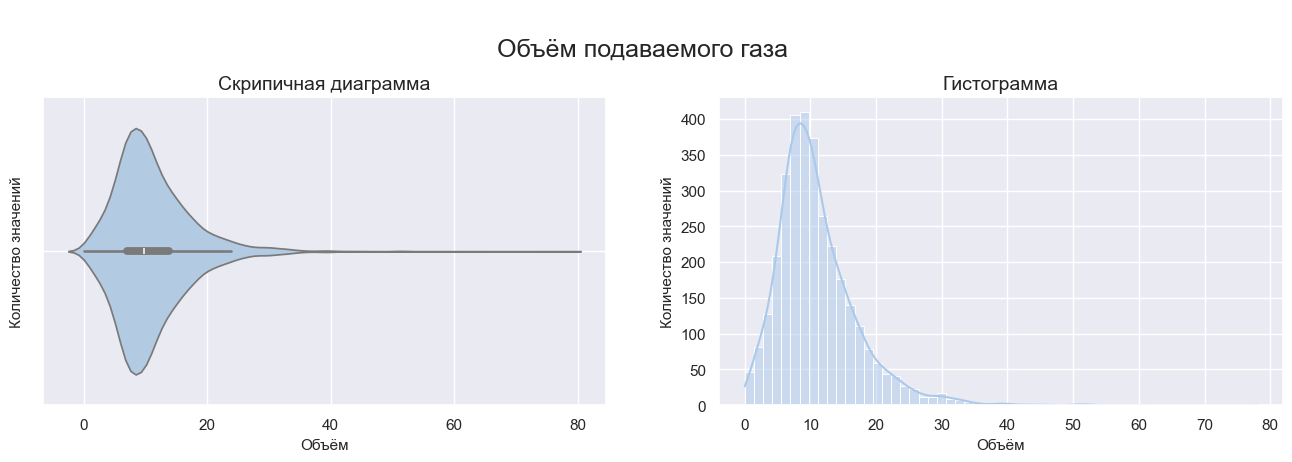

In [50]:
# выведем на экран гистограмму и скрипичную диаграмму

hist_violin(gas, 'gas_1', 56, 'Объём', 'Объём подаваемого газа')

Видим, что на графике есть выброс. Однако, он не мешает оценить распределение данных в столбце: в основном, объём подаваемого газа находится в диапазоне от 0 до 20, в нём же данные распределены нормально. Это подтверждает медиана, равная 9.8 и среднее, равное 11. Также согласно числовому описанию данных, мксимальный объём газа составляет 77.9, а минимальный — 0.008. 

Пропусков в таблице не было — из этого можно сделать вывод, что каждая партия всегда продувается инертным газом в том или ином количестве

In [51]:
# оценим количество наблюдений, в которых объём подаваемого газа превышает 50

gas.query('gas_1 > 50')

,key,gas_1
116,117,50.581035
277,280,60.935689
319,322,77.995040
2107,2110,52.142373
2567,2570,51.380229


Среди всех 3239 наблюдений выбросов всего лишь 5. Нет никаких причин думать, что эти данные являются ошибочными или аномальными, поэтому удалять их нельзя — модель должна учитывать эти значения

---

### `data_temp_new.csv`

In [52]:
# изучим общую информацию о таблице

get_info(temp)

Пять случайных строк таблицы:


,key,Время замера,Температура
14356,2568,2019-08-13 09:12:59,NaN
11469,2047,2019-07-25 04:52:47,1596.0
3146,563,2019-05-24 22:50:23,1599.0
15063,2693,2019-08-17 16:43:10,NaN
2760,488,2019-05-22 06:07:57,1611.0


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None


- таблица `data_temp_new` содержит 18092 строки и 3 столбца
- названия столбцов требуют переименования
- в обоих столбцах, кроме `key` тип данных определён неверно
- пропуски есть только в столбце `Температура`
- данные соответствуют описанию

---

In [53]:
# переименуем столбцы

temp_new_cols = ['key', 'measurement_time', 'temp']
temp.columns = temp_new_cols

# проверим результат

print('Обновлённый список столбцов:', temp.columns.to_list())

Обновлённый список столбцов: ['key', 'measurement_time', 'temp']


In [54]:
# проверим таблицу на наличие дубликатов

print(f'Дубликатов найдено в таблице temp: {temp.duplicated().sum()}')

Дубликатов найдено в таблице temp: 0


---

In [55]:
# посмотрим, какую долю составляют пропуски в столбце с целевым признаком

print(f"{'Доля пропущенных значений в столбце temp'}: {100 - (temp['temp'].count() / len(temp['temp'])) * 100:.2f}%")

Доля пропущенных значений в столбце temp: 18.94%


Температура сплава — целевой признак, поэтому строки с пропусками в этом столбце не принесут никакой пользы, их следует удалить.

Кроме того, условие задачи гласит: «Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова производят измерения [температуры]. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки». Это означает, что нам также будут полезны только те записи, в которых замер температуры произведён как минимум дважды

In [56]:
# избавимся от пропусков в таблице

temp = temp.dropna()

# проверим результат

print(f'Количество записей, оставшихся после удаления пропусков: {temp.shape[0]}')

Количество записей, оставшихся после удаления пропусков: 14665


In [57]:
# избавимся от записей о тех партиях, в которых замер температуры производился менее двух раз

temp = temp[temp['key'].isin(temp['key'].value_counts()[temp['key'].value_counts() >= 2].index)]

print(f'Количество записей, оставшихся после удаления строк с единственным замером: {temp.shape[0]}')

Количество записей, оставшихся после удаления строк с единственным замером: 13924


In [58]:
# ещё раз проверим таблицу на наличие пропусков и дубликатов

preprocess(temp, 'temp')

В таблице temp не найдено ни одного пропуска!
В таблице temp не найдено ни одного дубликата!


In [59]:
# изменим типы данных в столбцах

temp['measurement_time'] = pd.to_datetime(temp['measurement_time'], format='%Y-%m-%d %H:%M:%S')
temp['temp'] = temp['temp'].astype(int)

# проверим результат

print('Обновлённый список типов данных в таблице data_temp_new:')
print(' ')
print(temp.dtypes)

Обновлённый список типов данных в таблице data_temp_new:
 
key                          int64
measurement_time    datetime64[ns]
temp                         int32
dtype: object


---

In [60]:
# посмотрим, за какой период производились замеры

print(f"Дата первого замера температуры: {temp['measurement_time'].min()}")
print(f"Дата последнего замера температуры: {temp['measurement_time'].max()}")

Дата первого замера температуры: 2019-05-03 11:02:04
Дата последнего замера температуры: 2019-08-10 13:58:58


---

Известна нижняя граница температуры плавления — 1400 градусов. Срез данных сформируем до проведения исследовательского анализа

In [61]:
# сформируем срез данных

temp = temp.query('temp > 1400')

# проверим результат

print(f'Количество записей, оставшихся после удаления температурных выбросов: {temp.shape[0]}')

Количество записей, оставшихся после удаления температурных выбросов: 13920


Удалено всего 4 выброса по нижней границе!

In [62]:
# теперь посмотрим на числовое описание данных

describe(temp, 'temp', 'temp')

Числовое описание столбца temp таблицы temp:
 
count    13920.000000
mean      1590.911494
std         18.774355
min       1515.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: temp, dtype: float64


В среднем, температура сплава составляет ~1591 градус, минимальная температура составила 1515 градусов, а максимальная — 1705. Медиана практически идентична среднему — 1590 градусов

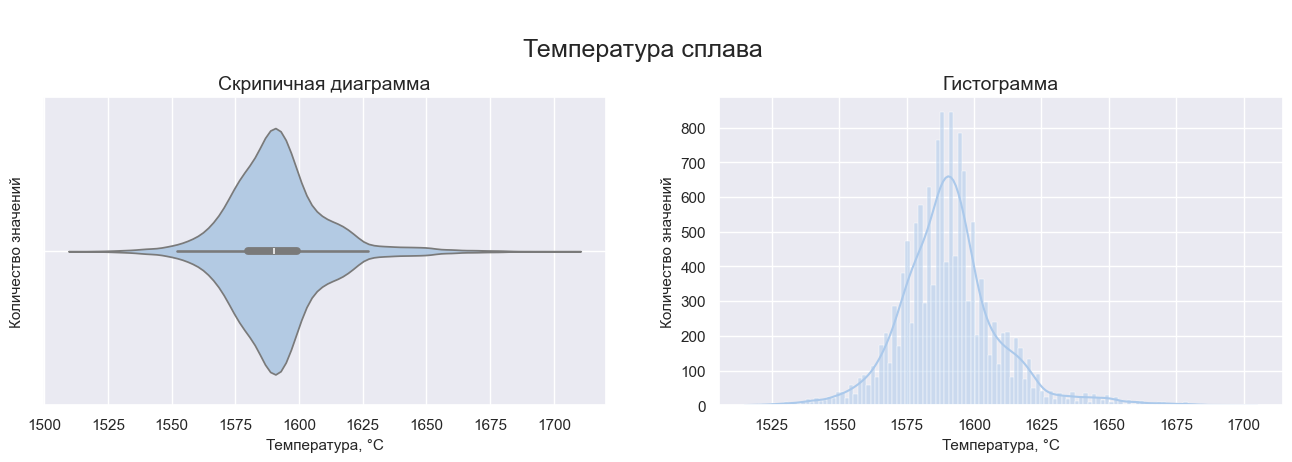

In [63]:
# выведем на экран гистограмму и скрипичную диаграмму

hist_violin(temp, 'temp', 118, 'Температура, °C', 'Температура сплава')

Можно сказать, что данные нормально распределены вокруг отметки в 1590 градусов. Ни аномалий, ни выбросов по обе стороны не наблюдается 

---

### `data_wire_new.csv`

In [64]:
# изучим общую информацию о таблице

get_info(wire)

Пять случайных строк таблицы:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
179,196,83.254082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2323,2448,129.030716,24.097839,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2646,2780,56.085121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1415,1487,63.086399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None


- таблица `data_wire_new` содержит 3081 строку и 10 столбцов
- названия столбцов требуют переименования
- пропуски есть во всех столбцах, кроме `key`
- типы данных определены верно
- данные соответствуют описанию

---

In [65]:
# переименуем столбцы

wire.columns = wire.columns.str.replace(' ', '_').str.lower()

# проверим результат

print('Обновлённый список столбцов:', wire.columns.to_list())

Обновлённый список столбцов: ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']


In [66]:
# проверим таблицу на наличие дубликатов

print(f'Дубликатов найдено: {bulk.duplicated().sum()}')

Дубликатов найдено: 0


---

In [67]:
# посмотрим, какую долю составляют пропуски в этой таблице

print('Доля пропущенных значений в файле data_wire_new:')
print(' ')
print(wire.apply(lambda x: f"{100 - (x.count() / len(x)) * 100:.2f}%"))

Доля пропущенных значений в файле data_wire_new:
 
key        0.00%
wire_1     0.84%
wire_2    64.98%
wire_3    97.96%
wire_4    99.55%
wire_5    99.97%
wire_6    97.63%
wire_7    99.64%
wire_8    99.38%
wire_9    99.06%
dtype: object


Таблица содержит данные об объёме подаваемых проволочных материалов. Судя по долям пропущенных значений, чаще всего сплаву подают проволочный материал 1-2 раза. Или, другими словами, добиваются нужного химического состава с помощью 1-2 подач материала.

Аналогично файлу с данными о подаче сыпучего материала, пропуски в таблице означают отсутствие этой самой подачи. Заменим их нулями

In [68]:
# заменим пропущенные значения нулями

wire = wire.fillna(0)

In [69]:
# снова проверим таблицу на наличие пропусков

preprocess(bulk, 'bulk')

В таблице bulk не найдено ни одного пропуска!
В таблице bulk не найдено ни одного дубликата!


---

In [70]:
# посмотрим на числовое описание всей таблицы

wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492
std,932.996726,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1619.000000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2434.000000,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


В таблице не наблюдаем ни выбросов, ни аномальных значений. Заметно, что с каждой подачей объём материала уменьшается. Чтобы отобразить это графически, возьмём средние значения каждой партии и вычислим среднее этих средних по каждому столбцу

In [71]:
# сформируем сводную таблицу

wire_cols = wire.columns[1:].tolist()
wire_pivot = wire.pivot_table(index='key', values=wire_cols, aggfunc='mean').mean()

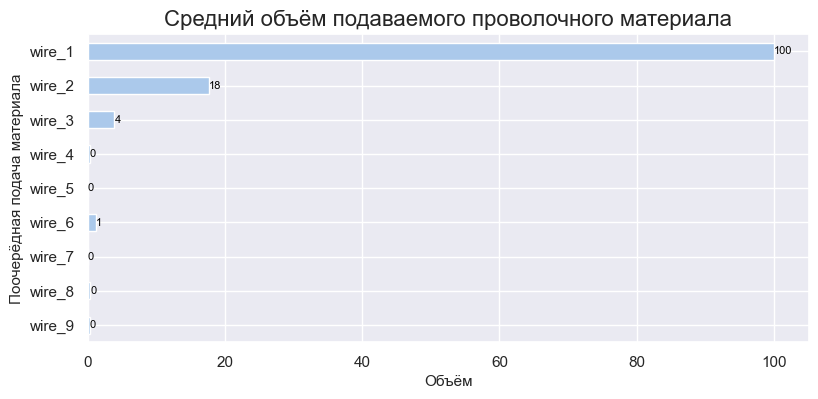

In [72]:
# построим столбчатую диаграмму 

barh_pivot(wire_pivot, 'Объём', 'Поочерёдная подача материала', 'Средний объём подаваемого проволочного материала')

В отличие от сыпучего материала, проволочный материал подаётся в большом объёме только при первых трёх подачах. Всё это в совокупности может быть связано с химическими особенностями процесса

---

### `data_wire_time_new.csv`

In [73]:
# изучим общую информацию о таблице

get_info(wire_time)

Пять случайных строк таблицы:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2516,2649,2019-08-16 07:07:06,2019-08-16 06:51:12,NaN,NaN,NaN,NaN,NaN,2019-08-16 06:42:52,NaN
197,219,2019-05-11 19:51:23,2019-05-11 19:43:17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1836,1926,2019-07-19 16:05:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999,2096,2019-07-26 20:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1141,1209,2019-06-18 05:38:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None


- таблица `data_wire_time_new` содержит 3081 строку и 10 столбцов
- названия столбцов требуют переименования
- пропуски есть во всех столбцах, кроме `key`
- типы данных определены неверно — все столбцы, кроме `key`, предположительно содержат временные ряды
- данные соответствуют описанию

---

In [74]:
# переименуем столбцы

wire_time.columns = wire_time.columns.str.replace(' ', '_').str.lower()

# проверим результат

print('Обновлённый список столбцов:', wire_time.columns.to_list())

Обновлённый список столбцов: ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']


In [75]:
# проверим таблицу на наличие дубликатов

print(f'Дубликатов найдено: {wire_time.duplicated().sum()}')

Дубликатов найдено: 0


---

In [76]:
# посмотрим, какую долю составляют пропуски в этой таблице

isna_share(wire_time, 'data_wire_time_new')

Доля пропущенных значений в файле data_wire_time_new:
 
key        0.00%
wire_1     0.84%
wire_2    64.98%
wire_3    97.96%
wire_4    99.55%
wire_5    99.97%
wire_6    97.63%
wire_7    99.64%
wire_8    99.38%
wire_9    99.06%
dtype: object


Пропуски в этой таблице точно так же совпадают с количеством пропусков в предыдущем файле — `data_wire_new`

In [77]:
# изменим тип данных с object на datetime

for i in range(1, 9+1):
    wire_time[f'wire_{i}'] = pd.to_datetime(wire_time[f'wire_{i}'], format='%Y-%m-%d %H:%M:%S')
    
# проверим результат

print('Обновлённый список типов данных в таблице data_wire_time_new:')
print(' ')
print(wire_time.dtypes)

Обновлённый список типов данных в таблице data_wire_time_new:
 
key                int64
wire_1    datetime64[ns]
wire_2    datetime64[ns]
wire_3    datetime64[ns]
wire_4    datetime64[ns]
wire_5    datetime64[ns]
wire_6    datetime64[ns]
wire_7    datetime64[ns]
wire_8    datetime64[ns]
wire_9    datetime64[ns]
dtype: object


In [78]:
# заменим пропущенные значения нулями

wire_time = wire_time.fillna(0)

# оценим результат

get_info(wire_time)

Пять случайных строк таблицы:


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
1156,1224,2019-06-18 17:10:20,0,0,0,0,0,0,0,0
2482,2609,2019-08-14 18:07:06,2019-08-14 17:53:38,0,0,0,0,0,0,0
54,63,2019-05-05 22:15:29,2019-05-05 22:07:40,0,0,0,0,0,0,0
80,95,2019-05-06 23:06:48,2019-05-06 22:52:53,0,0,0,0,0,0,0
1087,1154,2019-06-16 10:21:14,0,0,0,0,0,0,0,0


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3081 non-null   object
 2   wire_2  3081 non-null   object
 3   wire_3  3081 non-null   object
 4   wire_4  3081 non-null   object
 5   wire_5  3081 non-null   object
 6   wire_6  3081 non-null   object
 7   wire_7  3081 non-null   object
 8   wire_8  3081 non-null   object
 9   wire_9  3081 non-null   object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Исследовательский анализ данных завершён: переименованы столбцы в каждой таблице, удалены выбросы и пропуски в столбце с целевым признаком, изменены типы данных там, где это необходимо, основные закономерности данных изучены и отображены на графиках. Дубликатов в данных обнаружено не было. Данные готовы к созданию новых признаков
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Выбор и создание новых признаков для обучения моделей
</div>

---

Таблица `data_arc_new` содержит данные о времени и конце нагрева дугой, а также активной и реактивной мощностей. Из комбинации последниих двух признаков можно вычислить полную мощность, которая является векторной суммой активной и реактивной мощностей, по такой формуле:

$$ S = \sqrt{P^2 + Q^2} $$

где **P** — активная мощность, а **Q** — реактивная мощность

In [79]:
# создадим новый признак — полную мощность

arc['apparent_power'] = (((arc['active_power']**2) + (arc['reactive_power']**2)) ** 0.5)

# проверим результат

arc.head()

,key,heating_start,heating_end,active_power,reactive_power,apparent_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934


Кроме того, имея дату начала нагрева и дату конца нагрева дугой, можно вычислить суммарную длительность нагрева

In [80]:
# создадим ещё один новый признак — длительность нагрева в секундах

arc['heating_duration_total'] = (pd.to_datetime(arc['heating_end']) - pd.to_datetime(arc['heating_start'])).dt.total_seconds().astype(int)

# проверим результат

arc.head()

,key,heating_start,heating_end,active_power,reactive_power,apparent_power,heating_duration_total
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148


Теперь, когда у нас есть мощность и время в секундах, можем вычислить работу по такой формуле:

$$ A = Nt $$

где **N** — полная мощность, а **t** — длительность нагрева в секундах

In [81]:
# создадим новый признак — работу

arc['arc_work'] = arc['active_power'] * arc['heating_duration_total']

# проверим результат

arc.head()

,key,heating_start,heating_end,active_power,reactive_power,apparent_power,heating_duration_total,arc_work
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228,69.569640
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185,141.646730
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172,99.813836
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365,189.251040
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148,128.335684


In [82]:
# сформируем сводную таблицу на основе суммарных значений работы для каждой партии

arc_final = arc.pivot_table(index='key', values='arc_work', aggfunc='sum')

In [83]:
# создадим еще один признак для обучения — количество циклов нагрева для каждой партии

arc_final['heating_cycles'] = arc.pivot_table(index='key', values='heating_start', aggfunc='count')

# проверим результат

arc_final.head()

,arc_work,heating_cycles
key,,
1,628.616930,5
2,395.281800,4
3,581.774624,5
4,543.710274,4
5,412.180480,4


В эту же таблицу добавим другие нужные для обучения признаки — суммированные для каждой партии активную, реактивную и полную мощности, а также длительность нагрева в секундах

In [84]:
# добавим признаки в новую таблицу

arc_final['active_power_sum'] = arc.pivot_table(index='key', values='active_power', aggfunc='sum')
arc_final['reactive_power_sum'] = arc.pivot_table(index='key', values='reactive_power', aggfunc='sum')
arc_final['apparent_power_sum'] = arc.pivot_table(index='key', values='apparent_power', aggfunc='sum')
arc_final['heating_duration_sum'] = arc.pivot_table(index='key', values='heating_duration_total', aggfunc='sum')

# проверим результат

get_info(arc_final)

Пять случайных строк таблицы:


,arc_work,heating_cycles,active_power_sum,reactive_power_sum,apparent_power_sum,heating_duration_sum
key,,,,,,
2617,364.120117,4,3.237272,2.436174,4.053268,412
3219,543.090025,4,3.406028,2.651068,4.320907,544
1080,652.307712,3,2.734406,1.984548,3.379073,725
2733,749.384347,4,2.338813,1.717429,2.903109,1016
2506,775.279823,7,4.346885,3.089126,5.335937,1132


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
Index: 3214 entries, 1 to 3241
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   arc_work              3214 non-null   float64
 1   heating_cycles        3214 non-null   int64  
 2   active_power_sum      3214 non-null   float64
 3   reactive_power_sum    3214 non-null   float64
 4   apparent_power_sum    3214 non-null   float64
 5   heating_duration_sum  3214 non-null   int32  
dtypes: float64(4), int32(1), int64(1)
memory usage: 163.2 KB
None


---

Создадим ещё два признака на основе данных в таблицах `data_bulk_new` и `data_wire_new`. Для каждой партии суммируем общее количество подаваемых сыпучих и проволочных материалов и для каждого создадим новый столбец

In [85]:
# создадим новый признак в таблице data_bulk_new

bulk['bulk_total'] = bulk[bulk.columns[1:]].sum(axis=1)

# проверим результат

bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_total
0,1,0,0,0,43,0,0,0,0,0,0,0,206,0,150,154,553
1,2,0,0,0,73,0,0,0,0,0,0,0,206,0,149,154,582
2,3,0,0,0,34,0,0,0,0,0,0,0,205,0,152,153,544
3,4,0,0,0,81,0,0,0,0,0,0,0,207,0,153,154,595
4,5,0,0,0,78,0,0,0,0,0,0,0,203,0,151,152,584


In [86]:
# создадим новый признак в таблице data_wire_new

wire['wire_total'] = wire[wire.columns[1:]].sum(axis=1)

# проверим результат

wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_total
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


---

На основе данных из таблицы `data_temp_new` сформируем два новых признака — начальное и конечное значение температуры. Сделаем это с помощью аргументов `aggfunc='first'` и `aggfunc='last'` метода `pivot_table()`. Эти аргументы означают, что для каждой партии, определённой по ключу `key`, будут выбраны первое и последнее значения в столбце `temp`, иными словами — первый и последний замеры температуры для каждой партии. Для этих данных создадим новую таблицу 

In [87]:
# сформируем сводную таблицу и запишем в неё значение начальной температуры

temp_first_last = temp.pivot_table(index='key', values='temp', aggfunc='first')
temp_first_last.columns = ['first_temp']

# добавим столбец с конечной температурой

temp_first_last['last_temp'] = temp.pivot_table(index='key', values='temp', aggfunc='last')

# проверим результат

temp_first_last.head()

,first_temp,last_temp
key,,
1,1571,1613
2,1581,1602
3,1596,1599
4,1601,1625
5,1576,1602


Ещё один признак, касающийся температуры, будет представлять из себя разницу между временем последнего и первого замеров температуры, выраженную в секундах

In [88]:
# создадим новый признак в таблице temp_first_last

temp_first_last['measurement_time_diff'] = temp.pivot_table(index='key', values='measurement_time', aggfunc='last') - temp.pivot_table(index='key', values='measurement_time', aggfunc='first')
temp_first_last['measurement_time_diff'] = temp_first_last['measurement_time_diff'].dt.total_seconds().astype(int)

# проверим результат

temp_first_last.head()

,first_temp,last_temp,measurement_time_diff
key,,,
1,1571,1613,1714
2,1581,1602,1265
3,1596,1599,1753
4,1601,1625,1220
5,1576,1602,1536


In [89]:
# проверим получившуюся сводную таблицу

get_info(temp_first_last)

Пять случайных строк таблицы:


,first_temp,last_temp,measurement_time_diff
key,,,
115,1635,1547,6992
362,1581,1592,1326
112,1594,1582,3129
2136,1581,1607,1015
156,1595,1600,2143


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
Index: 2475 entries, 1 to 2499
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   first_temp             2475 non-null   int32
 1   last_temp              2475 non-null   int32
 2   measurement_time_diff  2475 non-null   int32
dtypes: int32(3)
memory usage: 48.3 KB
None




<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Определены признаки, которые будут использоваться в дальнейшей работе, добавлены следующие новые признаки: `arc_work`, `heating_cycles`, `bulk_total`, `wire_total`, `first_temp`, `last_temp`, `measurement_time_diff`, `active_power_sum`, `reactive_power_sum`, `apparent_power_sum` и `heating_duration_sum`
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Объединение данных
</div>

---

In [90]:
# объединим данные в финальную таблицу

final_data = (
    temp_first_last
    .merge(arc_final, how ='left', on='key')
    .merge(gas, how ='left', on='key')
    .merge(bulk, how ='left', on='key')
    .merge(wire, how ='left', on='key')
).set_index('key')

In [91]:
# проверим результат

final_data.head()

,first_temp,last_temp,measurement_time_diff,arc_work,heating_cycles,active_power_sum,reactive_power_sum,apparent_power_sum,heating_duration_sum,gas_1,...,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_total
key,,,,,,,,,,,,,,,,,,,,,
1,1571,1613,1714,628.616930,5,3.036730,2.142821,3.718736,1098,29.749986,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
2,1581,1602,1265,395.281800,4,2.139408,1.453357,2.588349,811,12.555561,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
3,1596,1599,1753,581.774624,5,4.063641,2.937457,5.019223,655,28.554793,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
4,1601,1625,1220,543.710274,4,2.706489,2.056992,3.400038,741,18.841219,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
5,1576,1602,1536,412.180480,4,2.252950,1.687991,2.816980,869,5.413692,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


In [92]:
# оценим количество пропусков в финальное таблице

isna_share(final_data, 'final_data')

Доля пропущенных значений в файле final_data:
 
first_temp               0.00%
last_temp                0.00%
measurement_time_diff    0.00%
arc_work                 0.00%
heating_cycles           0.00%
active_power_sum         0.00%
reactive_power_sum       0.00%
apparent_power_sum       0.00%
heating_duration_sum     0.00%
gas_1                    0.08%
bulk_1                   2.75%
bulk_2                   2.75%
bulk_3                   2.75%
bulk_4                   2.75%
bulk_5                   2.75%
bulk_6                   2.75%
bulk_7                   2.75%
bulk_8                   2.75%
bulk_9                   2.75%
bulk_10                  2.75%
bulk_11                  2.75%
bulk_12                  2.75%
bulk_13                  2.75%
bulk_14                  2.75%
bulk_15                  2.75%
bulk_total               2.75%
wire_1                   4.16%
wire_2                   4.16%
wire_3                   4.16%
wire_4                   4.16%
wire_5                

In [93]:
# удалим пропущенные значения

final_data = final_data.dropna()

In [94]:
# проверим результат

print(f'Количество строк финальной таблицы после удаления пропусков: {final_data.shape[0]}')

Количество строк финальной таблицы после удаления пропусков: 2329


Удалено ещё 5.89% от общего количества итоговых данных

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Исследовательский анализ данных в объединённой таблице
</div>

---

Теперь, когда все данные были объединены в итоговую таблицу, исследуем их на предмет новых закономерностей или выбросов

### `first_temp` и `last_temp`

In [95]:
# посмотрим на числовое описание данных в столбцах first_temp и last_temp

describe(final_data, 'first_temp', 'final_data')
print(' ')
describe(final_data, 'last_temp', 'final_data')

Числовое описание столбца first_temp таблицы final_data:
 
count    2329.000000
mean     1587.386003
std        23.619841
min      1519.000000
25%      1571.000000
50%      1587.000000
75%      1603.000000
max      1660.000000
Name: first_temp, dtype: float64
 
Числовое описание столбца last_temp таблицы final_data:
 
count    2329.000000
mean     1593.365393
std        11.200915
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: last_temp, dtype: float64


Начальная температура сплава варьируется в диапазоне от 1519 до 1660 градусов. В среднем она составляет 1587 градусов, медианное значение идентично среднему. При этом конечная температура партий колеблется между 1541 и 1653 градусами, среднее значение на 6 градусов выше аналогичного у изначальной температуры и составляет 1593 градуса, медиана также идентична среднему

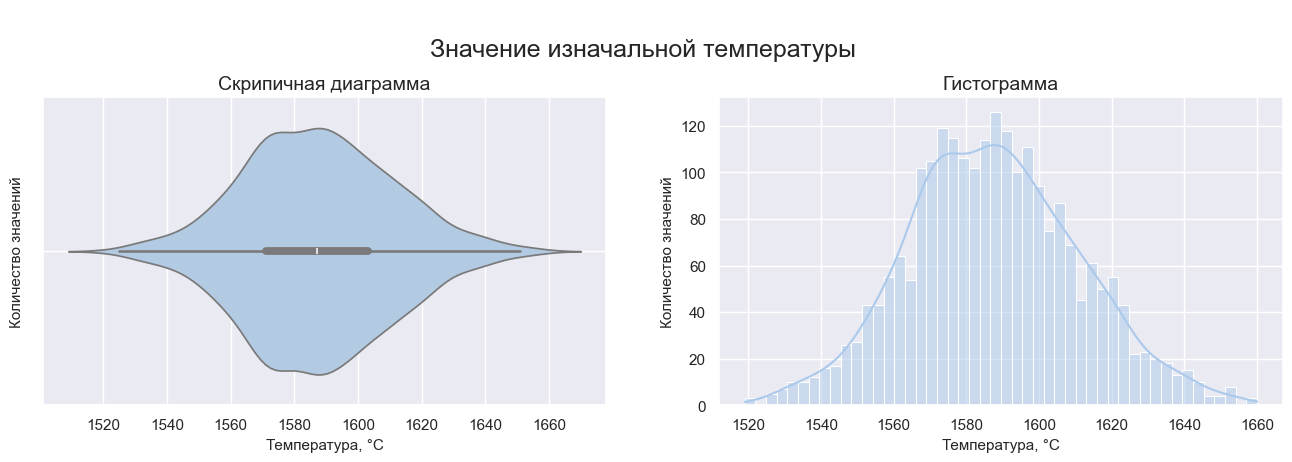

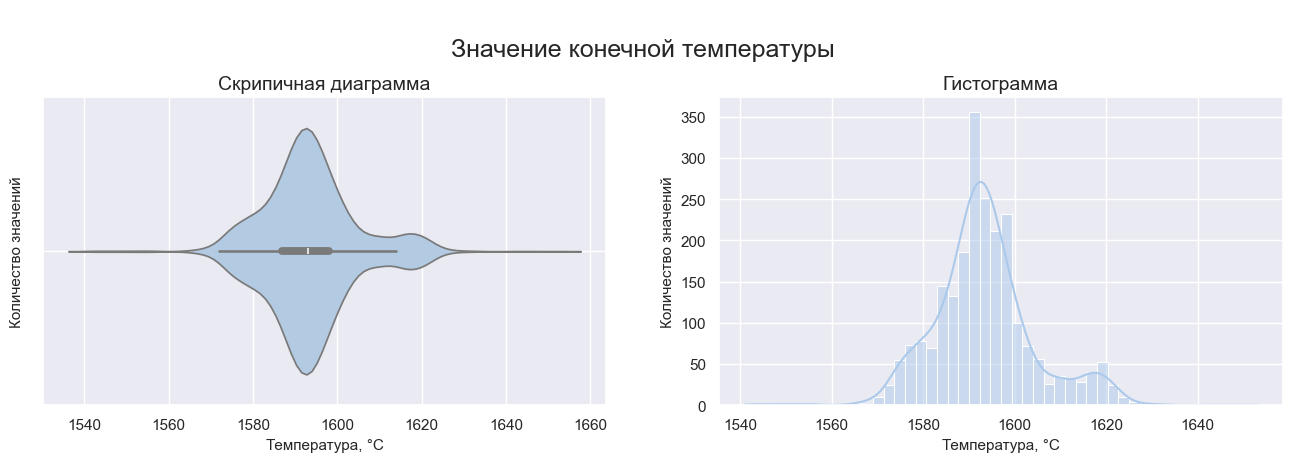

In [96]:
# выведем на экран гистограммы и скрипичную диаграммы

hist_violin(final_data, 'first_temp', 48, 'Температура, °C', 'Значение изначальной температуры')
hist_violin(final_data, 'last_temp', 48, 'Температура, °C', 'Значение конечной температуры')

В столбце с начальной температурой мы явно видим нормальное распределение, точнее — данные нормально распределены вокруг диапазона в 1570-1600 градусов. На графике с финальной температурой можно заметить уменьшение этого диапазона и уменьшение колебаний температуры. Выбросов не наблюдается в обоих столбцах

### `measurement_time_diff`

In [97]:
# посмотрим на числовое описание данных в столбцe measurement_time_diff

describe(final_data, 'measurement_time_diff', 'final_data')

Числовое описание столбца measurement_time_diff таблицы final_data:
 
count     2329.000000
mean      2321.810219
std       1385.191527
min        270.000000
25%       1579.000000
50%       2045.000000
75%       2791.000000
max      23674.000000
Name: measurement_time_diff, dtype: float64


В столбце `measurement_time_diff` находится временная разница между первым и последним замерами температуры, выраженная в секундах. Если 75% этих данных ограничены значением в 2791 секунду, то максимальное значение между замерами — 23674 секунды — скорее всего, является выбросом

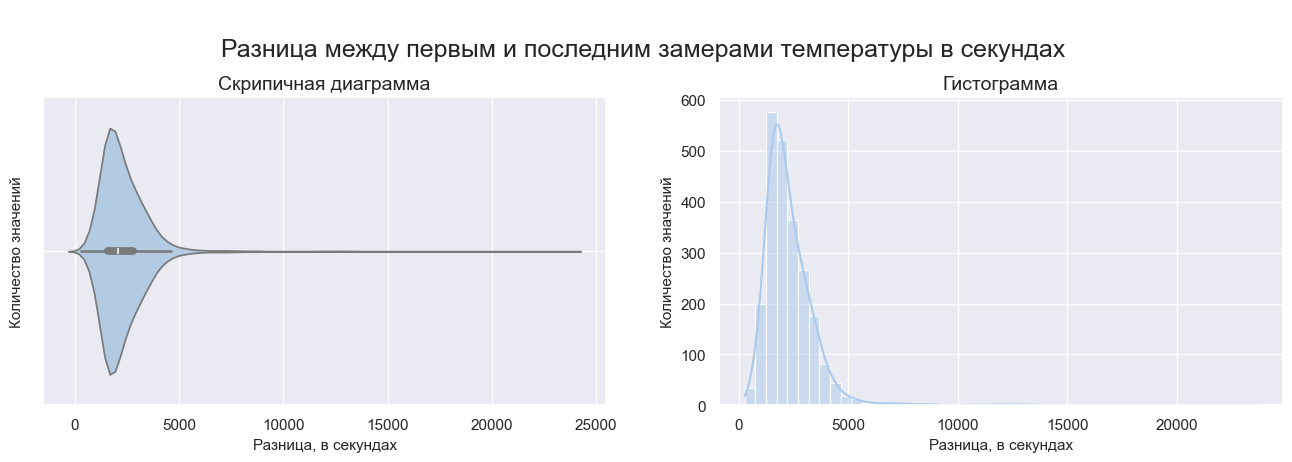

In [98]:
# выведем на экран гистограмму и скрипичную диаграмму

hist_violin(final_data, 'measurement_time_diff', 48, 'Разница, в секундах', 'Разница между первым и последним замерами температуры в секундах')

Значения секунд, не превыщающие 5000, ожидаемо нормально распределяются вокруг своей медианы. Чтобы сделать какой-то вывод о природе выбросов, сформируем срез данных, состоящий из тех строк, значение которых превышает 5000 секунд

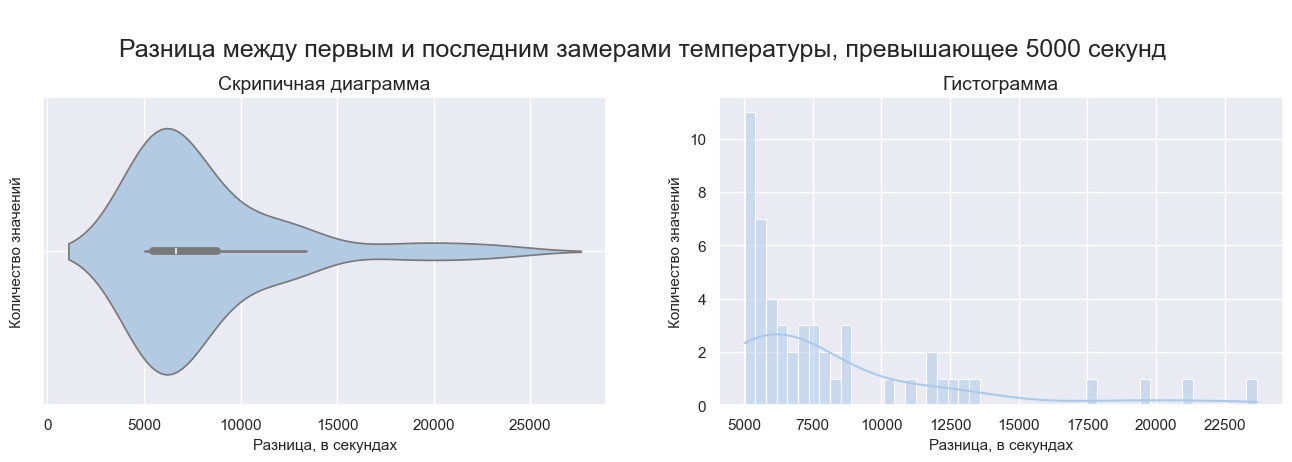

In [99]:
# сформируе срез 

final_query = final_data.query('measurement_time_diff > 5000')

# выведем на экран гистограмму и скрипичную диаграмму для этого среза

hist_violin(final_query, 'measurement_time_diff', 48, 'Разница, в секундах', 'Разница между первым и последним замерами температуры, превышающее 5000 секунд')

In [100]:
# посчитаем количество строк со временем, превышающим 5000 секунд

print(f'Количество строк со временем, превышающим 5000 секунд: {final_query.shape[0]}')

Количество строк со временем, превышающим 5000 секунд: 51


Так называемые выбросы составляют 2,2%. Невозможно сказать точно, является ли эта 51 строка выбросом, ведь уточнить у заказчика примерное время обработки каждой партии мы не можем. Максимальное значение — 23674 секунды — примерно равно 6,5 часам. График показывает, что количество замеров, превышающих 5000 секунд, равномерно уменьшается. Иными словами, мы не видим скопления нескольких аномально больших чисел по правой стороне графика. Оставим эти данные как данные об очень долгих партиях

### `arc_worc`

In [101]:
# посмотрим на числовое описание данных в столбцe arc_work

describe(final_data, 'arc_work', 'final_data')

Числовое описание столбца arc_work таблицы final_data:
 
count    2329.000000
mean      539.000381
std       257.277885
min        26.187544
25%       368.130458
50%       508.068106
75%       678.323372
max      3718.054401
Name: arc_work, dtype: float64


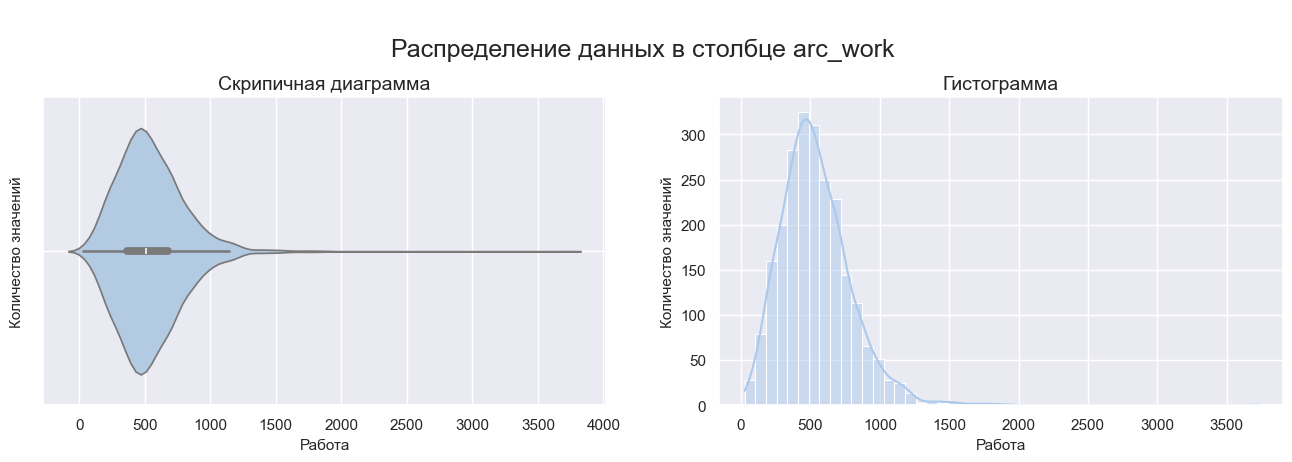

In [102]:
# выведем на экран гистограмму и скрипичную диаграмму

hist_violin(final_data, 'arc_work', 48, 'Работа', 'Распределение данных в столбце arc_work')

In [103]:
# подсчитаем количество выбросов

print(f"Количество выбросов в столбце arc_work: {final_data.query('arc_work > 1600').shape[0]}")

Количество выбросов в столбце arc_work: 7


Распределение данных в этом столбце нормальное, не считая выбросов по правой стороне графика

### `heating_cycles`

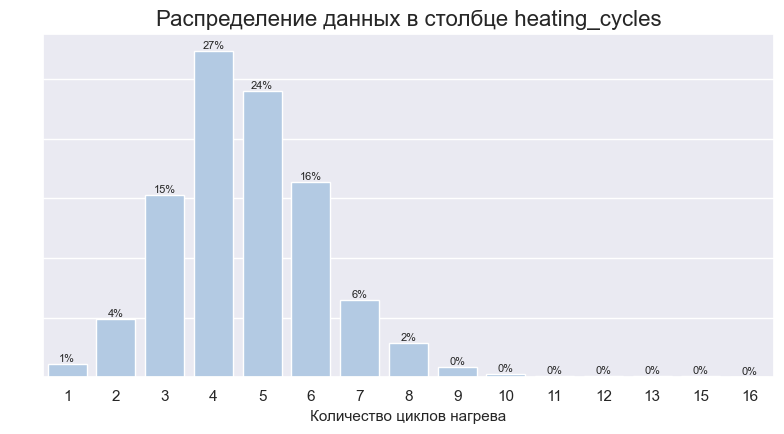

In [104]:
# выведем на экран столбчатую диаграмму

barplot_no_y(final_data, 'heating_cycles', 'Количество циклов нагрева', 'Распределение данных в столбце heating_cycles', normalize=True)

Чаще всего, а именно в 27% случаев, сплав проходит 4 цикла нагрева. Чуть реже — в 24% случаев — количество циклов составляет 5 штук. В 15% и 16% случаев количество циклов составляет 6 и 3 штуки соответственно. Таким образом, больше половины данных — 51% — проходят 4-5 циклов нагрева

### `heating_duration_sum`

In [105]:
# посмотрим на числовое описание данных в столбцe heating_duration_sum

describe(final_data, 'heating_duration_sum', 'final_data')

Числовое описание столбца heating_duration_sum таблицы final_data:
 
count    2329.000000
mean      807.647488
std       340.838388
min        57.000000
25%       581.000000
50%       778.000000
75%       993.000000
max      4189.000000
Name: heating_duration_sum, dtype: float64


Суммарное время нагрева для каждой партии находится в диапазоне от 57 до 4189 секунд. 4189 секунд — это почти 70 минут или чуть больше 1 часа. В среднем, суммарное время нагрева составляет 807 секунд или почти 14 минут

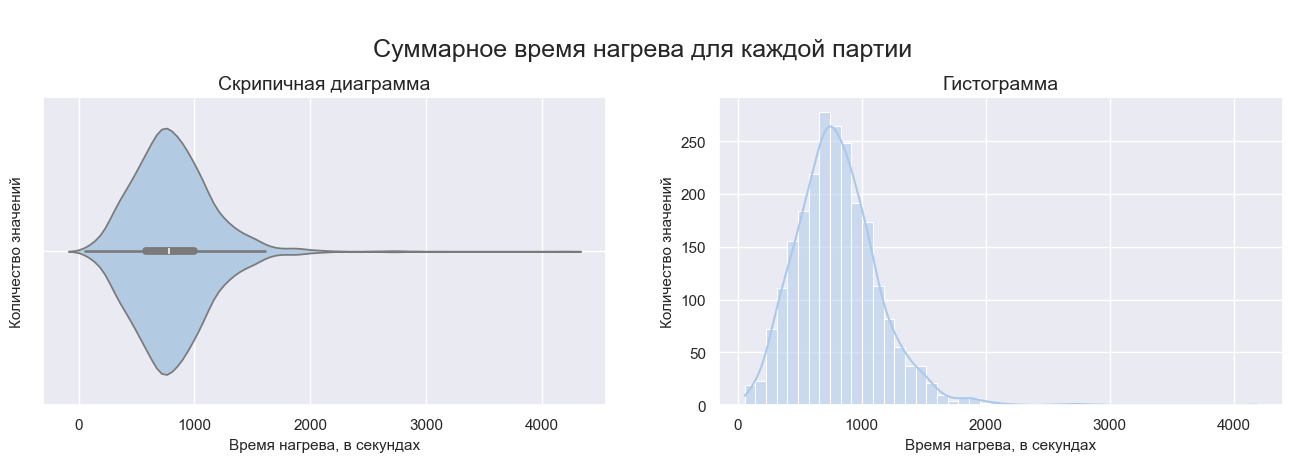

In [106]:
# выведем на экран гистограмму и скрипичную диаграмму

hist_violin(final_data, 'heating_duration_sum', 48, 'Время нагрева, в секундах', 'Суммарное время нагрева для каждой партии')

In [107]:
# внимательнеее рассмотрим строки, содержащие выбросы

final_data.query('heating_duration_sum > 2000')

,first_temp,last_temp,measurement_time_diff,arc_work,heating_cycles,active_power_sum,reactive_power_sum,apparent_power_sum,heating_duration_sum,gas_1,...,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_total
key,,,,,,,,,,,,,,,,,,,,,
44,1600,1603,10976,1142.634004,12,7.298996,5.221229,8.981145,2063,21.265271,...,69.189123,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,69.189123
45,1538,1621,4887,1270.648921,10,6.272281,4.564355,7.767906,2136,18.601690,...,114.354237,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,114.354237
46,1607,1612,12323,1832.006809,13,9.180259,7.051945,11.591736,2919,6.118441,...,100.245593,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,100.245593
322,1619,1616,7011,1635.245129,13,8.914806,6.564143,11.075555,2658,77.995040,...,0.000000,188.228550,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,188.228550
638,1588,1619,13408,1370.876001,11,7.270996,4.981813,8.817556,2067,19.798236,...,169.322388,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,169.322388
813,1548,1603,3946,1592.684208,9,6.099306,4.467993,7.564909,2247,19.856740,...,29.250000,85.141678,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,114.391678
1513,1553,1574,11692,1906.194897,15,11.632350,8.572990,14.466533,2526,38.471706,...,130.197596,60.229519,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,190.427115
1689,1583,1606,23674,3718.054401,15,12.375636,8.949049,15.288271,4189,33.597044,...,187.153206,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,187.153206
1880,1606,1615,11887,1520.171775,11,6.149070,4.263111,7.484913,2755,26.379596,...,70.199997,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,70.199997


Догадка о том, что эти выбросы стоит оставить в таблице, подтверждаются. Мы видим, что тем партиям, в которых зафиксированно необычно долгое время нагрева, соответствуют и выбросы из других столбцов, таких как значение работы, разница между временем первого и последнего замеров температуры, а также высокое количество циклов нагрева. Едва ли это результат ошибки, скорее — редкие, но значимые случаи

### `active_power_sum`, `reactive_power_sum` и `apparent_power_sum`

In [108]:
# посмотрим на числовое описание данных в столбцах active_power_sum, reactive_power_sum и apparent_power_sum

describe(final_data, 'active_power_sum', 'final_data')
describe(final_data, 'reactive_power_sum', 'final_data')
describe(final_data, 'apparent_power_sum', 'final_data')

Числовое описание столбца active_power_sum таблицы final_data:
 
count    2329.000000
mean        3.125336
std         1.220799
min         0.267676
25%         2.295820
50%         3.035365
75%         3.834300
max        12.375636
Name: active_power_sum, dtype: float64
Числовое описание столбца reactive_power_sum таблицы final_data:
 
count    2329.000000
mean        1.993317
std        14.869416
min      -713.966032
25%         1.669572
50%         2.225398
75%         2.829159
max         8.949049
Name: reactive_power_sum, dtype: float64
Числовое описание столбца apparent_power_sum таблицы final_data:
 
count    2329.000000
mean        4.191859
std        14.873681
min         0.331897
25%         2.844193
50%         3.769823
75%         4.770751
max       717.937368
Name: apparent_power_sum, dtype: float64


Наблюдаем знакомые выбросы в столбцах `reactive_power_sum` и `apparent_power_sum`

In [109]:
# подсчитаем количество выбросов в этих столбцах

print(f"Количество выбросов в столбце reactive_power_sum: {final_data.query('reactive_power_sum < 0').shape[0]}")
print(f"Количество выбросов в столбце apparent_power_sum: {final_data.query('apparent_power_sum > 10').shape[0]}")

Количество выбросов в столбце reactive_power_sum: 1
Количество выбросов в столбце apparent_power_sum: 7


Эти выбросы выглядят слишком большими и их количество достаточно маленькое. Лучше избавиться от них — вряд ли они нам пригодятся.

Однако удалять их, как и другие подобные им выбросы, лучше только из тренировочной выборки. Если обучать модель стоит на чистых данных, то тестирование должно проходить на реальных неочищенных данных

In [110]:
# сформируем срез без выбросов, чтобы оценить распределение данных

final_data_query = final_data.query('reactive_power_sum > 0 & apparent_power_sum < 10')

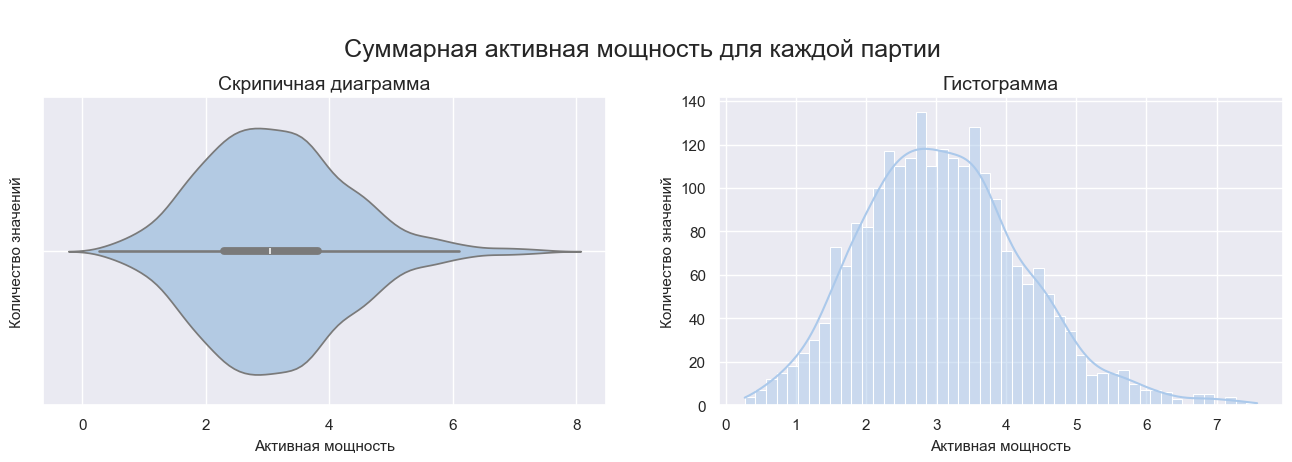

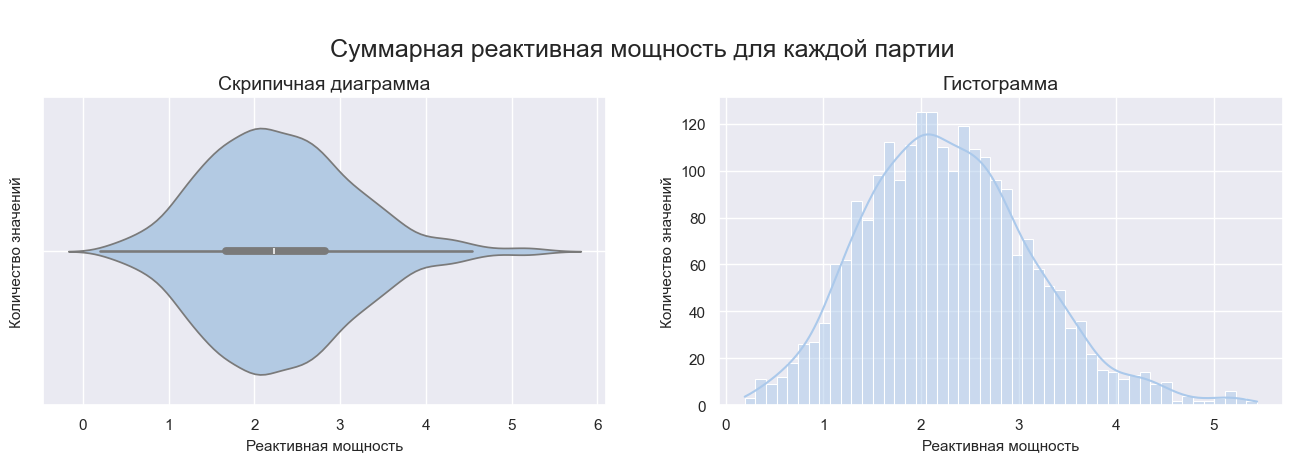

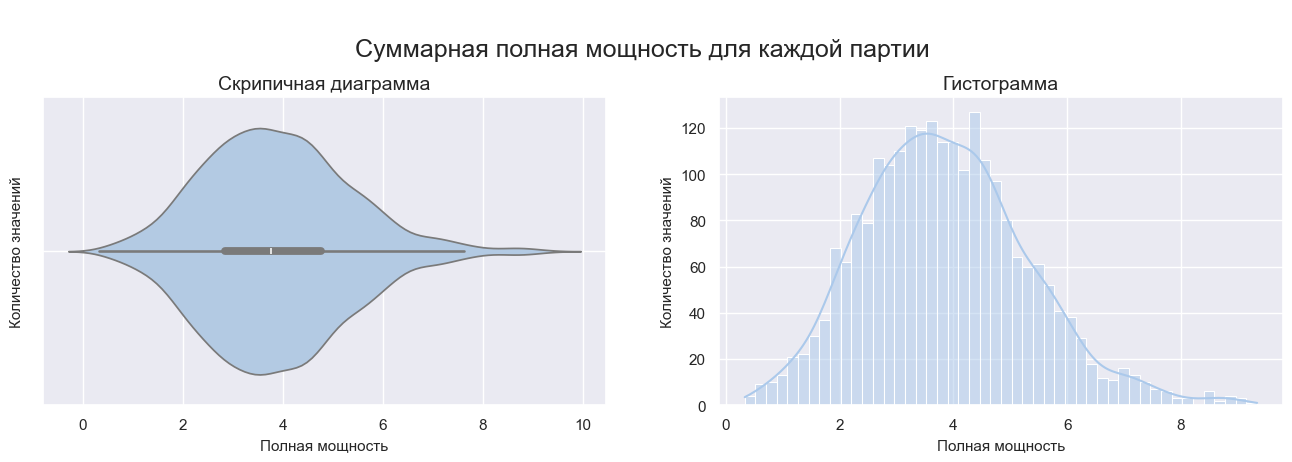

In [111]:
# выведем на экран гистограммы и скрипичную диаграммы

hist_violin(final_data_query, 'active_power_sum', 48, 'Активная мощность', 'Суммарная активная мощность для каждой партии')
hist_violin(final_data_query, 'reactive_power_sum', 48, 'Реактивная мощность', 'Суммарная реактивная мощность для каждой партии')
hist_violin(final_data_query, 'apparent_power_sum', 48, 'Полная мощность', 'Суммарная полная мощность для каждой партии')

Во всех трёх столбцах видим нормально распределённые данные, что соответствует их природе

### `bulk_total` и `wire_total`

In [112]:
# посмотрим на числовое описание данных в столбцах bulk_total и wire_total

describe(final_data, 'bulk_total', 'final_data')
describe(final_data, 'wire_total', 'final_data')

Числовое описание столбца bulk_total таблицы final_data:
 
count    2329.000000
mean      609.630313
std       287.599678
min        19.000000
25%       440.000000
50%       609.000000
75%       795.000000
max      3235.000000
Name: bulk_total, dtype: float64
Числовое описание столбца wire_total таблицы final_data:
 
count    2329.000000
mean      125.208530
std        63.683386
min         1.918800
25%        89.013596
50%       116.101440
75%       151.568558
max       568.777664
Name: wire_total, dtype: float64


Столбцы содержат суммарные данные о подаче сыпучего и проволочного материалов в каждой партии. В них есть выбросы, но они, как и выбросы в предыдущих столбцах итоговой таблицы, не выглядят как ошибка. Проверим количество этих выбросов и посмотрим на строки, в которых они содержатся

In [113]:
# подсчитаем количество выбросов в столбцах bulk_total и wire_total

print(f"Количество выбросов в столбце bulk_total: {final_data.query('bulk_total > 1500').shape[0]}")
print(f"Количество выбросов в столбце wire_total: {final_data.query('wire_total > 300').shape[0]}")

Количество выбросов в столбце bulk_total: 4
Количество выбросов в столбце wire_total: 40


In [114]:
# внимательнеее рассмотрим строки, содержащие выбросы

display(final_data.query('bulk_total > 1500').describe(), final_data.query('wire_total > 300').describe())

,first_temp,last_temp,measurement_time_diff,arc_work,heating_cycles,active_power_sum,reactive_power_sum,apparent_power_sum,heating_duration_sum,gas_1,...,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_total
count,4.000000,4.00,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.000000
mean,1606.000000,1605.25,8938.000000,1796.755366,9.75000,7.669456,5.644229,9.529139,2201.750000,31.076426,...,96.060122,47.057138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.117259
std,35.543401,13.50,10048.466052,1350.720763,4.99166,3.809906,2.696983,4.672956,1559.382864,33.833328,...,76.468943,94.114275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.486157
min,1572.000000,1586.00,2442.000000,594.808260,5.00000,3.660062,2.780566,4.598665,704.000000,4.898431,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.016404
25%,1580.250000,1601.00,2579.250000,1077.887321,5.75000,5.210507,3.907510,6.515215,1118.000000,7.086001,...,72.762303,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.307259
50%,1601.000000,1609.50,4818.000000,1437.079402,9.50000,7.321064,5.423650,9.114810,1957.000000,20.706117,...,98.543640,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.612042
75%,1626.750000,1613.75,11176.750000,2155.947447,13.50000,9.780014,7.160369,12.128734,3040.750000,44.696543,...,121.841459,47.057138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187.422042
max,1650.000000,1616.00,23674.000000,3718.054401,15.00000,12.375636,8.949049,15.288271,4189.000000,77.995040,...,187.153206,188.228550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,188.228550


,first_temp,last_temp,measurement_time_diff,arc_work,heating_cycles,active_power_sum,reactive_power_sum,apparent_power_sum,heating_duration_sum,gas_1,...,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_total
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,...,40.000000,40.000000,40.000000,40.0,40.0,40.000000,40.0,40.000000,40.000000,40.000000
mean,1587.425000,1591.350000,2771.925000,608.807086,5.325000,3.631809,2.676971,4.516354,887.025000,15.280639,...,145.140995,98.247422,160.295344,0.0,0.0,3.636204,0.0,2.569060,4.378920,414.267945
std,29.414707,9.379601,1272.157755,228.723504,1.685344,1.212436,0.883854,1.498399,286.530124,4.864570,...,47.430076,73.280871,134.879671,0.0,0.0,13.347072,0.0,16.248162,12.623615,78.040740
min,1534.000000,1577.000000,1297.000000,78.265642,1.000000,0.486122,0.344489,0.595808,161.000000,7.126257,...,74.131195,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,301.517837
25%,1561.750000,1585.750000,1952.000000,509.785009,4.000000,3.026746,2.166802,3.723467,700.500000,11.710614,...,113.805901,46.657520,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,340.947360
50%,1585.000000,1589.000000,2592.000000,565.577673,5.000000,3.564000,2.626683,4.411705,922.000000,14.652501,...,141.245521,85.126599,234.282054,0.0,0.0,0.000000,0.0,0.000000,0.000000,405.662729
75%,1608.750000,1594.250000,3260.000000,719.762427,6.000000,4.125279,3.056029,5.114289,1056.000000,18.638414,...,169.406631,144.783083,277.056785,0.0,0.0,0.000000,0.0,0.000000,0.000000,481.423542
max,1645.000000,1615.000000,7893.000000,1157.185658,10.000000,7.147568,5.153126,8.817530,1406.000000,28.362796,...,330.314424,282.780152,385.008668,0.0,0.0,65.310967,0.0,102.762401,55.000397,568.777664


Видим, что выбросы в столбцах с суммарным объёмом подаваемого материала принадлежат тем строка или партиям, в которых разница во времени между первым и последним замерами температуры, а также время нагрева гораздо выше среднего. То есть, эти строки также относятся к очень долгим партиям, эти партии можно охарактеризовать как очень объёмные или сложные в связи с какими-нибудь нюансами изначального сплава, материалов или химического состава. Удалять эти выбросы, как было сказано ранее, мы не будем

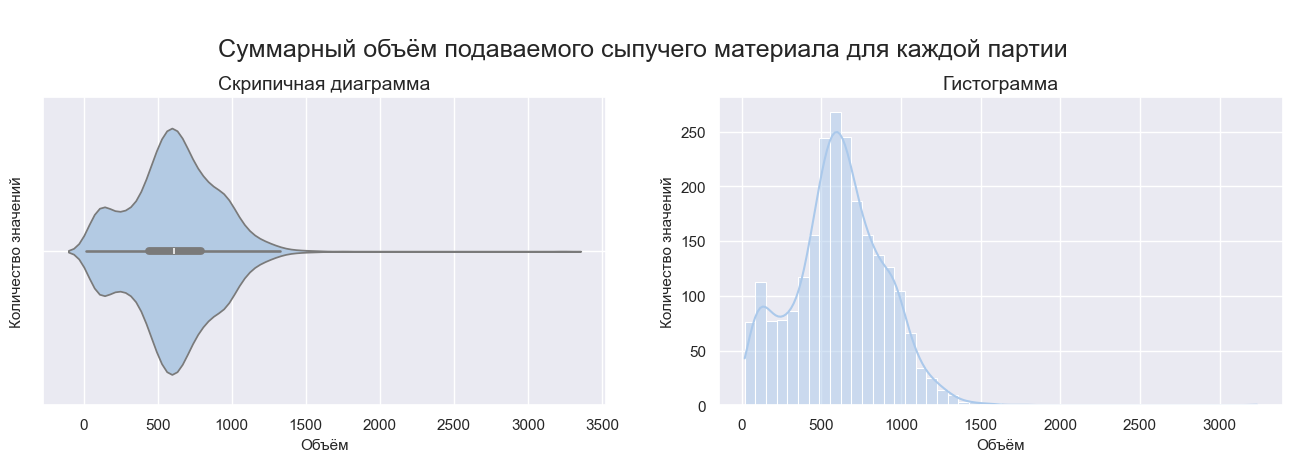

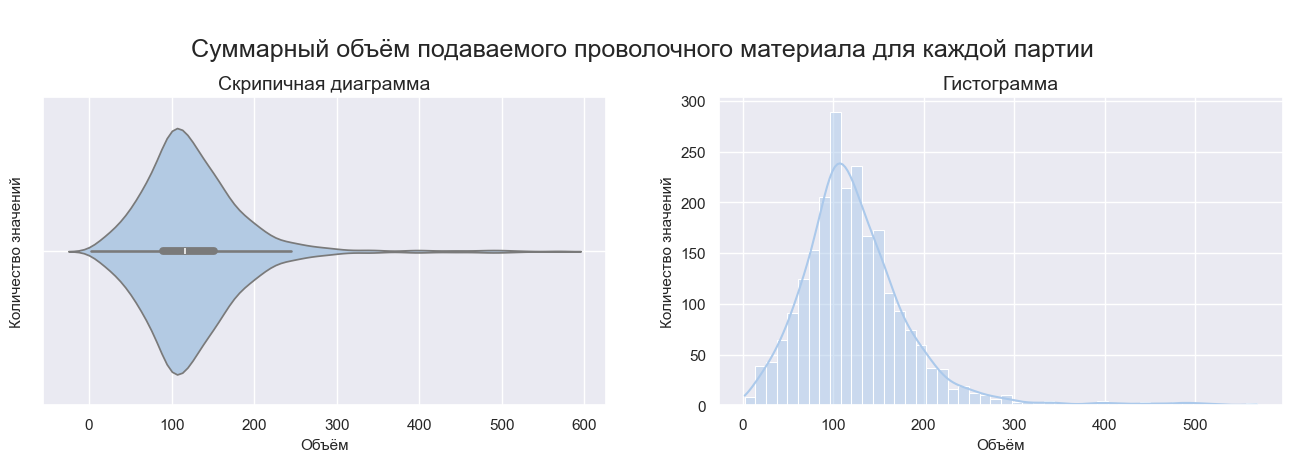

In [115]:
# выведем на экран гистограммы и скрипичную диаграммы

hist_violin(final_data, 'bulk_total', 48, 'Объём', 'Суммарный объём подаваемого сыпучего материала для каждой партии')
hist_violin(final_data, 'wire_total', 48, 'Объём', 'Суммарный объём подаваемого проволочного материала для каждой партии')

На графике столбца `bulk_total` можно заметить, что значения сосредоточены в двух областях — примерно от 0 до 200 и от 500 до 700, график скошен влево. На графике с объёмом проволочного материала данные нормально распределены вокруг значения в 100, график также скошен влево

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Из итоговой таблицы, объединяющей выбранные из данных и созданные на их основе новые признаки, были удалены выбросы в столбцах `active_power_sum` и `reactive_power_sum`. Объединённая таблица была исследована на предмет новых закономерностей, распределение всех признаков отображено графически
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Корреляционный анализ данных
</div>

---

In [116]:
def phik(data, interval_cols):
    
    """
    Функция phik выводит на экран матрицу корреляции phik

    Аргументы:
    data (DataFrame) : датафрейм
    interval_cols (list) : список названий столбцов, содержащих непрерывные количественные признаки
    
    """

    phik_matrix = data.phik_matrix(interval_cols=interval_cols)
    cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
    plt.figure(figsize=(30, 30))
    sns.heatmap(phik_matrix, annot=True, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={'shrink': .8})
    plt.xticks(rotation=60)
    plt.title(r'Матрица корреляции $\phi_K$')

    plt.show()

---

Оценим, как признаки взаимосвязаны между собой. Так как в данных содержатся как категориальные, так и числовые признаки, используем метод Phik. Перед построением матрицы корреляции не требуется проводить статистический тест для определения нормальности распределений, поскольку Phik не предполагает нормальность данных. Однако, он требует определения непрерывных признаков вручную

In [117]:
# создадим список с наименованиями непрерывных признаков

interval_cols = [col for col in final_data.columns if col != 'heating_duration_cycle']

# проверим результат

print(f'Список непрерывных признаков: {interval_cols}')

Список непрерывных признаков: ['first_temp', 'last_temp', 'measurement_time_diff', 'arc_work', 'heating_cycles', 'active_power_sum', 'reactive_power_sum', 'apparent_power_sum', 'heating_duration_sum', 'gas_1', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'bulk_total', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9', 'wire_total']


Непрерывными являются все имеющиеся признаки, кроме количества циклов нагрева, содержащегося в столбце `heating_duration_cycle`

In [118]:
# в связи с ошибкой, появляющейся при построении матрицы корреляции, изучим столбец wire_5

final_data['wire_5'].unique()

array([0.])

В ошибке сказано, что столбец `wire_5` содержит недостаточно уникальных значений для какого-либо анализа. В столбце действительно остались лишь нули, поэтому удалим его

In [119]:
# избавимся от столбца wire_5

final_data = final_data.drop(['wire_5'], axis=1)

Также перед тем, как графически отобразить матрицу корреляции, найдём признаки с мультиколлинеарностью и удалим их. О мультиколлинеарности, как правило, говорят при значении коэффициента от 0.9 и выше по модулю

In [120]:
# найдём коррелирующие друг с другом пары признаков

corr_pairs = find_high_correlation(final_data)

# выведем результат на экран

print('Пары признаков, коэффициент корреляции которых составил более 0.9:')
display(corr_pairs)

Пары признаков, коэффициент корреляции которых составил более 0.9:


[('apparent_power_sum', 'reactive_power_sum'),
 ('heating_duration_sum', 'arc_work'),
 ('wire_8', 'bulk_9')]

Видим, что активная и реактивная мощность сильно коррелируют с полной мощностью — признаком, который мы создали с помощью формулы. Удалим признак `reactive_power_sum`, так как он является парой для двух других признаков. Также избавимся от `wire_8`, сильно коррелирующим с `bulk_9`

In [121]:
# избавимся от признаков reactive_power_sum и wire_8

final_data = final_data.drop(['reactive_power_sum', 'wire_8'], axis=1)

In [122]:
# проверим результат

corr_pairs = find_high_correlation(final_data)

# выведем результат на экран

print('Пары признаков, коэффициент корреляции которых составил более 0.9:')
display(corr_pairs)

Пары признаков, коэффициент корреляции которых составил более 0.9:


[('heating_duration_sum', 'arc_work')]

Появилась новая пара. Удалим признак `arc_work` и проверим результат снова

In [123]:
# избавимся от признака arc_work

final_data = final_data.drop(['arc_work'], axis=1)

In [124]:
# проверим результат ещё раз

corr_pairs = find_high_correlation(final_data)

# выведем результат на экран

print('Пары признаков, коэффициент корреляции которых составил более 0.9:')
display(corr_pairs)

Пары признаков, коэффициент корреляции которых составил более 0.9:


[]

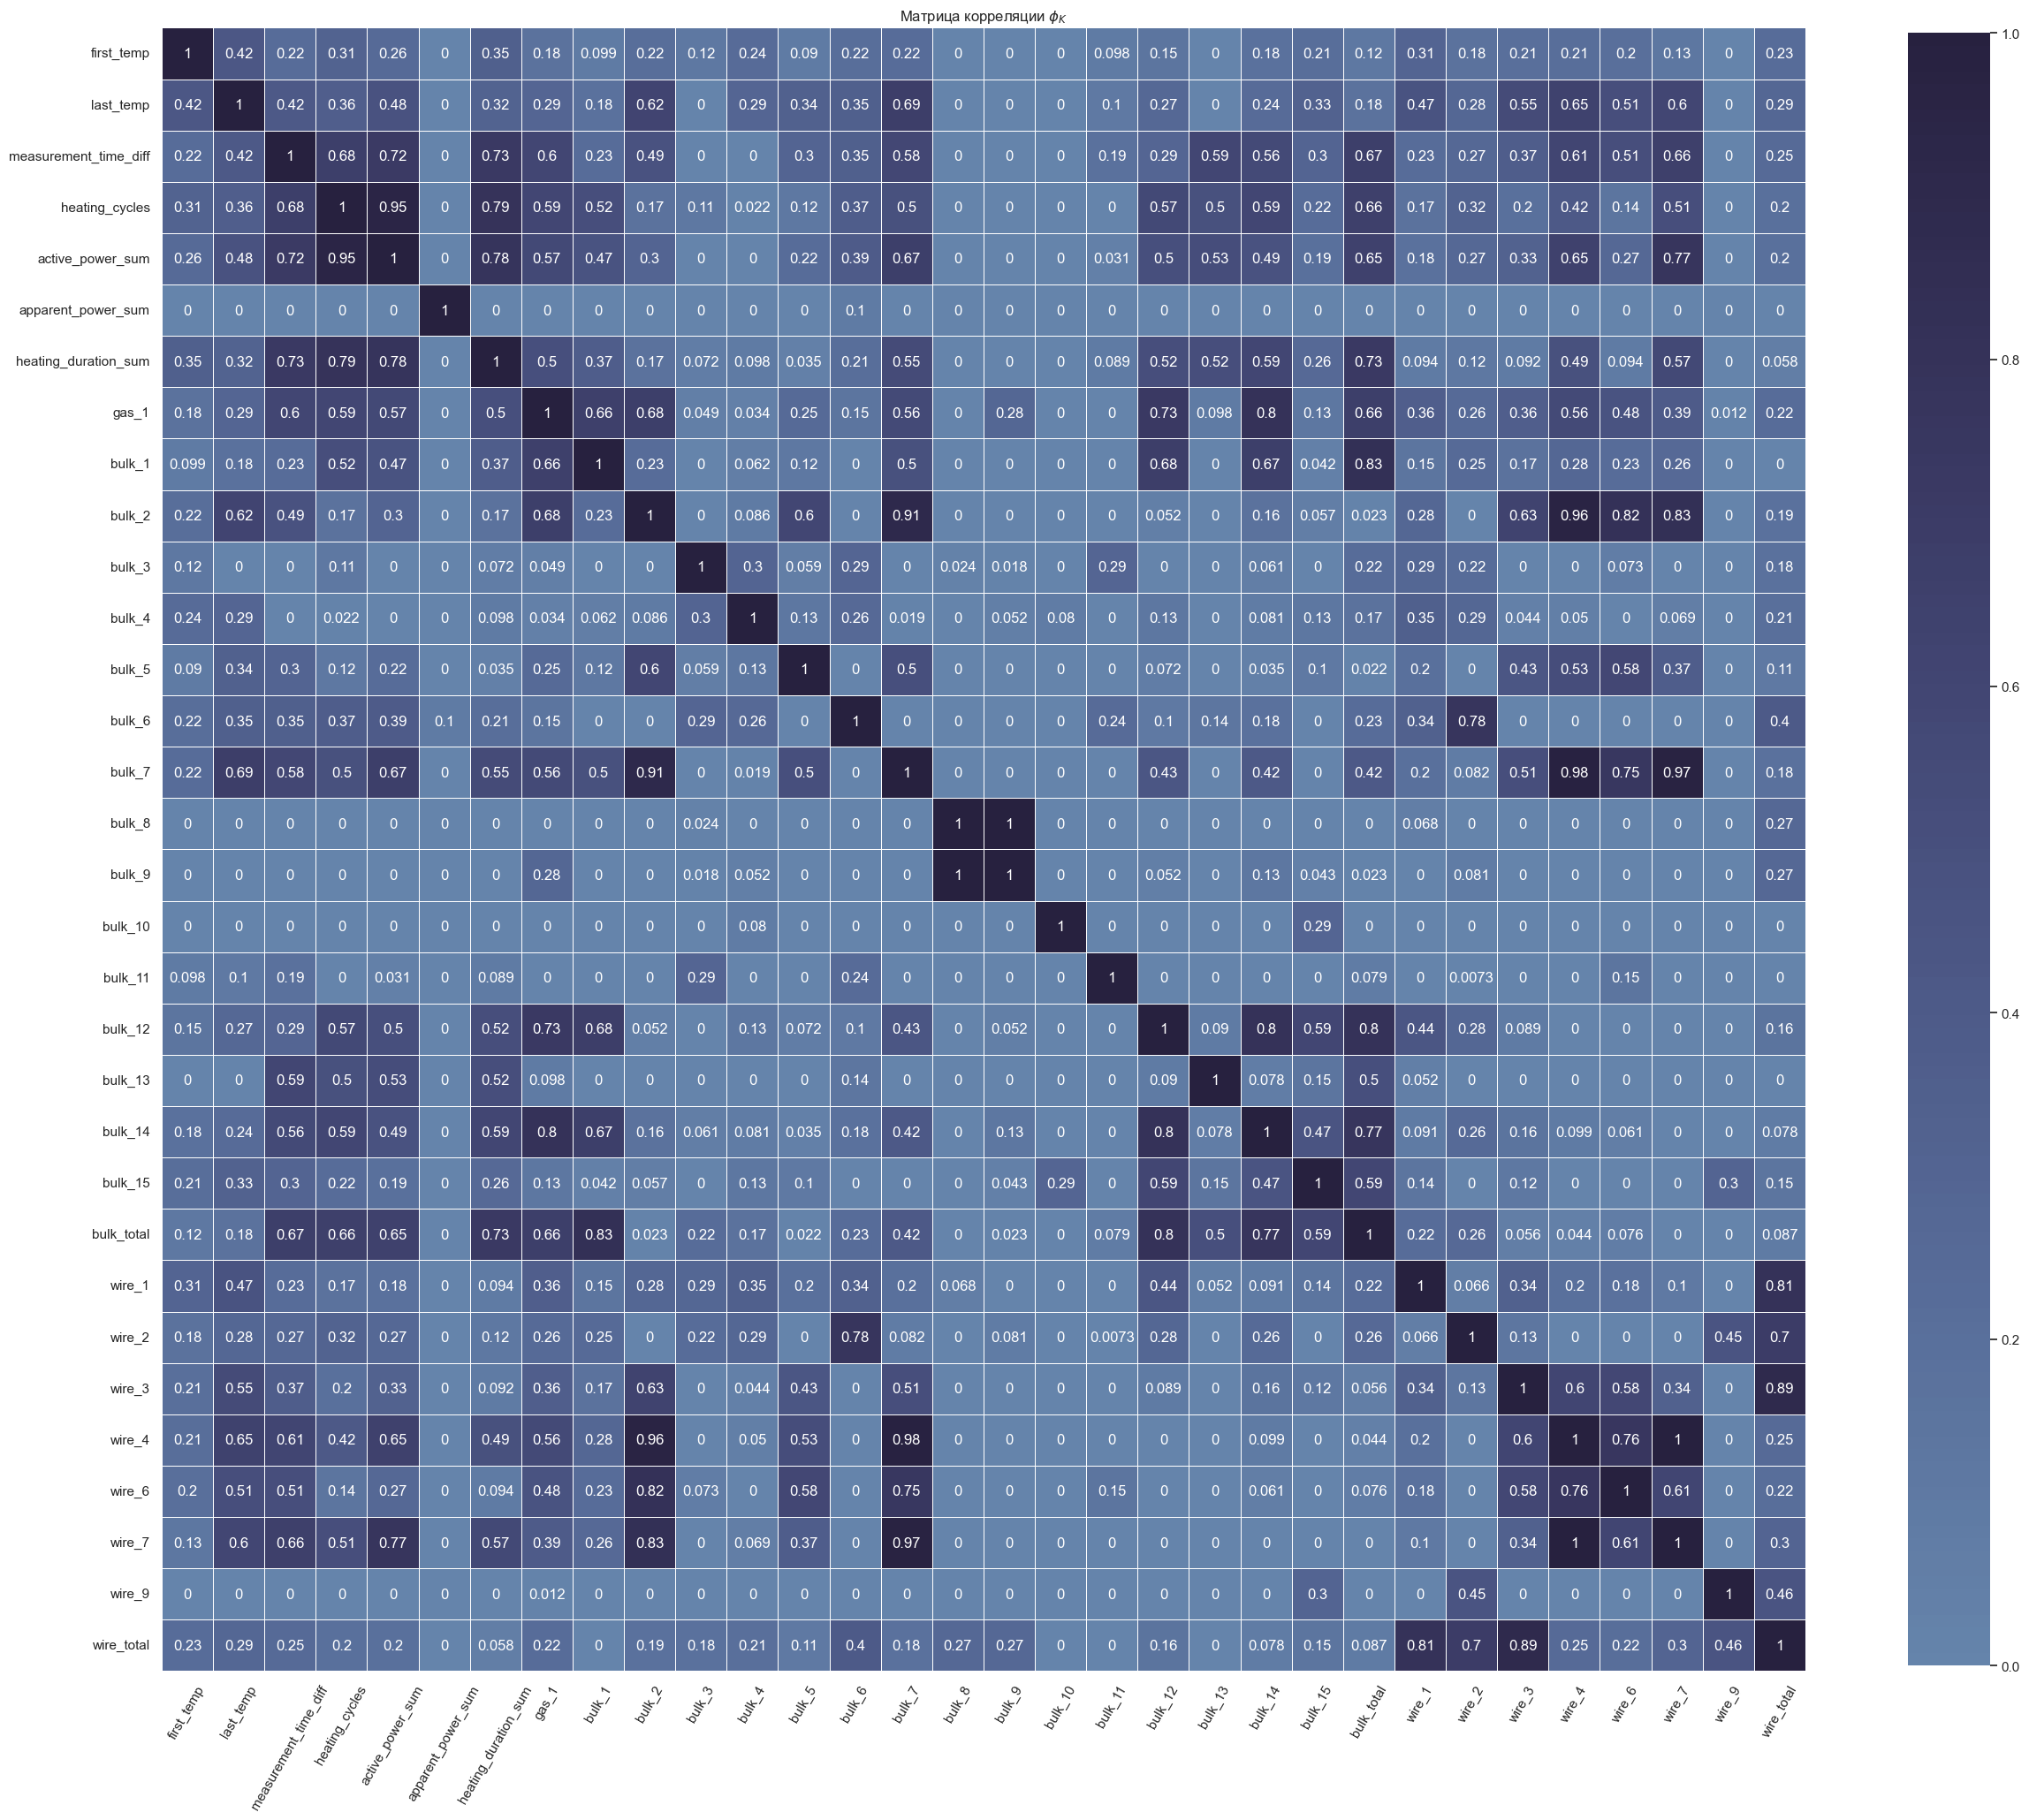

In [125]:
# выведем на экран матрицу корреляции

phik(final_data, interval_cols)

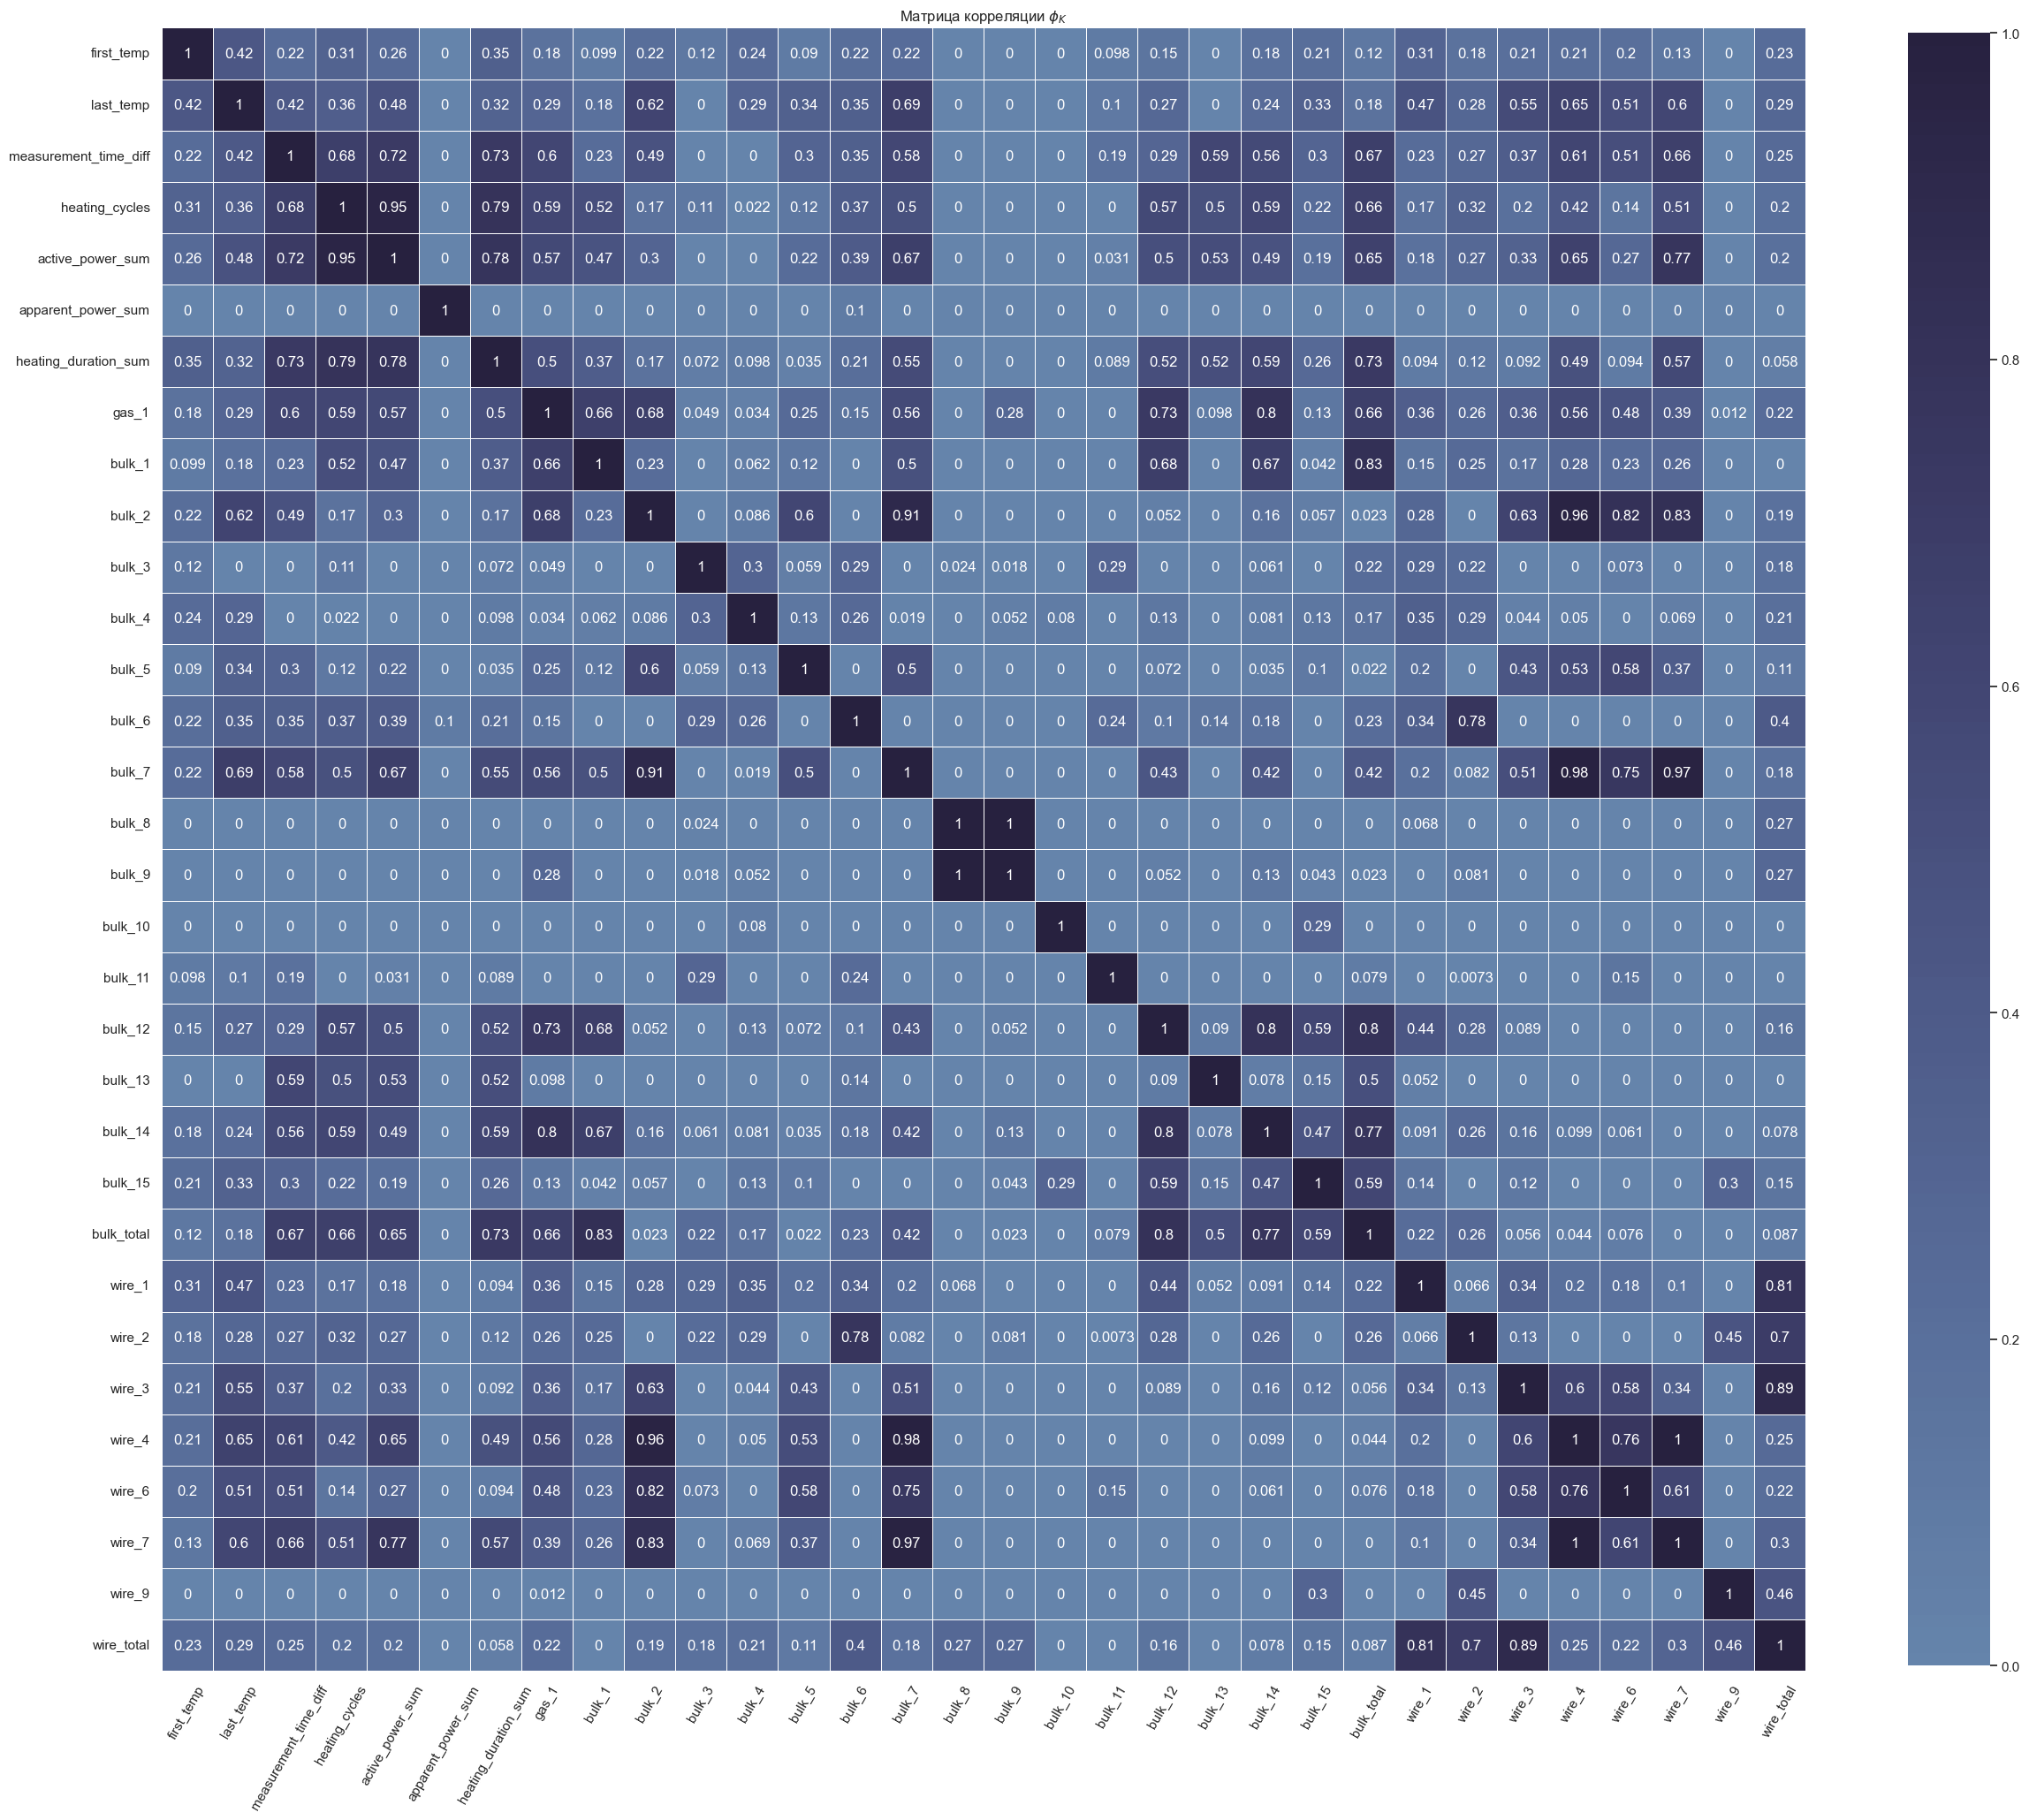

In [126]:
# выведем на экран матрицу корреляции

phik(final_data, interval_cols)

На графике мы видим ещё один высокий коэффициент корреляции — 0.98, который не был обнаружен функцией. Видимо, это связано с тем, что метод Phik способен обнаруживать не только линейную зависимость, но и нелинейную. Избавимся от этого признака

In [127]:
# избавимся от признака wire_4

final_data = final_data.drop(['wire_4'], axis=1)

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Судя по матрице корреляции, есть множество пар признаков, имеющих значительную взаимную корреляцию — от 0.7 до 0.9. В их число входит признак `wire_total`, образуя пары с `wire_1`, `wire_2` и `wire_3`. Это вполне логичная взаимосвязь — суммарный объём проволочного материала ожидаемо зависит от объёма материала, поданного в какой-либо из циклов. Аналогичная ситуация и у признака `bulk_total` — он образует пары с признаками `bulk_12`, `bulk_14` и `bulk_15`. Также корреляция в этом диапазоне наблюдается у пар признаков `wire_7` и `bulk_7`, `wire_6` и `bulk_2`, `wire_7` и `wire_6`, `wire_6` и `bulk_7`, `wire_2` и `bulk_6`, `bulk_12` и `bulk_15`, `bulk_14` и `bulk_12`, `bulk_15` и `bulk_12`, `bulk_7` и `bulk_2`, `gas_1` и `wire_1`, `gas_1` и `bulk_2`. Признаки `bulk_8`, `bulk_10` и `wire_9` практически не коррелируют ни с одним из остальных признаков, так же как и `bulk_3` и `bulk_4`. Из этого сделаем вывод, что, за исключением нескольких циклов подач материала, данные об объёме подаваемых в партию материалов и газа прочно связаны между собой. 

Время нагрева коррелирует в том же диапазоне — от 0.7 до 0.9 — с `arc_work`, `heating_cycles` и `apparent_power_sum`, и умеренно — от 0.5 до 0.7 — с `bulk_12`, `bulk_14` и `bulk_total`, что тоже вполне ожидаемо — количество материалов будет влиять на время нагрева, ведь сплав нагревают после каждой подачи нового материала. Полная мощность также высоко коррелирует с признаком `arc_work` (ведь второй признак следует из первого) и с признаками `heating_cycles` и `heating_duration_sum`, касающимися непосредственно нагрева сплава. Они, в свою очередь, оказывают ощутимое влияние и на `arc_work`, а также высоко коррелируют друг с другом. 

Что касается начальной температуры сплава, она умеренно, но достаточно ощутимо зависит от признаков `bulk_2`, `bulk_7` и `wire_7`. А вот целевой признак — конечная температура — показывают слабую корреляцию со всеми остальными признаками
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Подготовка данных к обучению
</div>

---

In [128]:
def split(data, target):
                                        
    """
    Функция split делит данные на тренировочную и тестовую выборки
    
    Аргументы:
    data (DataFrame) : датафрейм
    target (str) : целевой признак
    
    """
    
    X = data.drop(columns=[TARGET])
    y = data[TARGET]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE
    )
    
    return X_train, X_test, y_train, y_test

In [129]:
def train_test_size(X_train, X_test, y_train, y_test):
                                    
    """
    Функция train_test_size выводит на экран размерность разделённых на выборки данных
    
    Аргументы:
    X_train (DataFrame) : входные признаки тренировочной выборки
    X_test (DataFrame) : входные признаки тестовой выборки
    y_train (Series) : целевой признак тренировочной выборки
    y_test (Series) : целевой признак тестовой выборки
    
    """

    print('Тренировочная выборка')
    print(f'Размерность матрицы со входными признаками: {X_train.shape}')
    print(f'Размерность матрицы с целевым признаком: {y_train.shape}')
    print(' ')
    print('Тестовая выборка')
    print(f'Размерность матрицы со входными признаками: {X_test.shape}')
    print(f'Размерность матрицы с целевым признаком: {y_test.shape}')

---

In [130]:
# выведем информацию об итоговой таблице на экран

get_info(final_data)

Пять случайных строк таблицы:


,first_temp,last_temp,measurement_time_diff,heating_cycles,active_power_sum,apparent_power_sum,heating_duration_sum,gas_1,bulk_1,bulk_2,...,bulk_14,bulk_15,bulk_total,wire_1,wire_2,wire_3,wire_6,wire_7,wire_9,wire_total
key,,,,,,,,,,,,,,,,,,,,,
431,1601,1620,1942,5,2.534916,3.194607,868,10.656761,0.0,0.0,...,151.0,153.0,621.0,122.194802,0.000000,0.0,0.0,0.0,0.0,122.194802
667,1586,1602,1616,5,2.738610,3.376383,780,9.115819,0.0,0.0,...,202.0,154.0,915.0,129.214798,0.000000,0.0,0.0,0.0,0.0,129.214798
590,1555,1598,1940,5,3.513666,4.388473,1202,11.707244,0.0,0.0,...,255.0,405.0,1169.0,109.043999,0.000000,0.0,0.0,0.0,0.0,109.043999
420,1598,1592,3352,6,4.436097,5.492642,706,14.244007,0.0,0.0,...,128.0,218.0,694.0,181.350006,0.000000,0.0,0.0,0.0,0.0,181.350006
2452,1601,1610,3523,7,3.834300,4.793956,1256,16.618648,0.0,0.0,...,145.0,205.0,654.0,126.147835,20.086559,0.0,0.0,0.0,0.0,146.234394


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
Index: 2329 entries, 1 to 2499
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   first_temp             2329 non-null   int32  
 1   last_temp              2329 non-null   int32  
 2   measurement_time_diff  2329 non-null   int32  
 3   heating_cycles         2329 non-null   int64  
 4   active_power_sum       2329 non-null   float64
 5   apparent_power_sum     2329 non-null   float64
 6   heating_duration_sum   2329 non-null   int32  
 7   gas_1                  2329 non-null   float64
 8   bulk_1                 2329 non-null   float64
 9   bulk_2                 2329 non-null   float64
 10  bulk_3                 2329 non-null   float64
 11  bulk_4                 2329 non-null   float64
 12  bulk_5                 2329 non-null   float64
 13  bulk_6                 2329 non-null   float64
 14  bulk_7                 2329 n

Разделим итоговые данные на тренировочную и тестовую выборки, в которые войдёт 75% и 25% данных соответственно

In [131]:
# создадим копию итоговой таблицы

final_data_copy = final_data.copy()

In [132]:
# разделим данные на тренировочную и тестовую выборки

X_train, X_test, y_train, y_test = split(final_data_copy, TARGET)

In [133]:
# проверим результат

train_test_size(X_train, X_test, y_train, y_test)

Тренировочная выборка
Размерность матрицы со входными признаками: (1746, 30)
Размерность матрицы с целевым признаком: (1746,)
 
Тестовая выборка
Размерность матрицы со входными признаками: (583, 30)
Размерность матрицы с целевым признаком: (583,)


In [134]:
# проверим корректность размера тестовой выборки

print(f'Размер тестовой выборки относительно изначального набора данных: {X_test.shape[0] / final_data_copy.shape[0]}')

Размер тестовой выборки относительно изначального набора данных: 0.25032202662086733


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Выборки были сформированы корректно. Можно приступать к обучению моделей
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Обучение моделей
</div>

---

Необходимо отметить, что в данном случае модель линейной регрессии использована не была по той причине, что корреляционный анализ данных показал нелинейную зависимость между входными и целевым признаками. Это значит, что, скорее всего, линейная регрессия не покажет приемлемый результат. Вместо этого, для обучения были выбраны следующие модели: `Random Forest`, `Cat Boost`, `Gradient Boosting` и `XGBoost`. Целевой метрикой является `Mean Abosolute Error`, меньшая или равная 6.8

---

In [135]:
def randomized_search(params, model):
    
    """
    Функция randomized_search производит кросс-валидацию с помощью RandomizedSearchCV,
    обучает инициализированную модель с лучшими гиперпарамтрами на тренировочных данных,
    измеряет время, затраченное на обучение модели
    
    Аргументы:
    params (dict) : гиперпараметры
    model : инициализированная модель
    
    Возвращает:
    total_min : время, затраченное на обучение модели на тренировочных данных, в минутах
    mae : метрика итоговой модели, MAE
    best_params : параметры лучшей модели
    
    """
    
    rs = RandomizedSearchCV(model, params, scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, verbose=1, random_state=RANDOM_STATE)
    
    start = time()
    rs.fit(X_train, y_train)
    end = time()
    
    total_min = (end - start) / 60
    mae = abs(rs.best_score_)
    best_params = rs.best_params_
    
    return total_min, mae, best_params, rs

In [136]:
def randomized_search_results(total_min, mae, best_params, model_name):
    
    """
    Функция randomized_search_results выводит на экран время, затраченное на обучение,
    метрику MAE итоговой модели и её лучшие параметры
    
    Аргументы:
    total_min : время, затраченное на обучение модели на тренировоных данных, в минутах
    mae : метрика итоговой модели, выражена в MAE
    best_params (dict) : параметры лучшей модели
    model_name (str) : название модели
    
    """
    
    print(' ')
    print(f'Время, затраченное на обучение модели на тренировочных данных, в минутах: {total_min}')
    print(' ')
    print(f'MAE: {mae}')
    print(' ')
    print(f'Лучшие параметры модели {model_name}:')
    print(best_params)

---

### `Gradient Boosting`

In [137]:
# создадим словарь с гиперпараметрами

gb_params = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(1, 11),
    'learning_rate': uniform(0.01, 0.99),
    'subsample': uniform(0.5, 0.5)
}

# инициализируем модель

gb_model = GradientBoostingRegressor(random_state=RANDOM_STATE)

In [138]:
# выполним подбор гиперпараметров и обучим модель на тренировочных данных

gb_total_min, gb_mae, gb_best_params, gb = randomized_search(gb_params, gb_model)

# оценим результат

randomized_search_results(gb_total_min, gb_mae, gb_best_params, 'Gradient Boosting')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
 
Время, затраченное на обучение модели на тренировочных данных, в минутах: 1.070053772131602
 
MAE: 5.894011460971136
 
Лучшие параметры модели Gradient Boosting:
{'learning_rate': 0.04305921062402978, 'max_depth': 3, 'n_estimators': 176, 'subsample': 0.7500479597915473}


###  `XGBoost`

In [139]:
# создадим словарь с гиперпараметрами

xgb_params = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'min_child_weight': randint(1, 10)
}

# инициализируем модель

xgb_model = XGBRegressor()

In [140]:
# выполним подбор гиперпараметров и обучим модель на тренировочных данных

xgb_total_min, xgb_mae, xgb_best_params, xgb = randomized_search(xgb_params, xgb_model)

# оценим результат

randomized_search_results(xgb_total_min, xgb_mae, xgb_best_params, 'XGBoost')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
 
Время, затраченное на обучение модели на тренировочных данных, в минутах: 0.3766785979270935
 
MAE: 5.877584970531237
 
Лучшие параметры модели XGBoost:
{'colsample_bytree': 0.7140691999028965, 'learning_rate': 0.077594906276645, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 184, 'subsample': 0.7687146966865592}


### `Cat Boost`

In [141]:
# создадим словарь с гиперпараметрами

cb_params = {
    'iterations': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.5],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128],
    'boosting_type': ['Ordered', 'Plain']
}

# инициализируем модель

cb_model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False, iterations=50, eval_metric='MAE')

In [142]:
# выполним подбор гиперпараметров и обучим модель на тренировочных данных

cb_total_min, cb_mae, cb_best_params, cb = randomized_search(cb_params, cb_model)

# оценим результат

randomized_search_results(cb_total_min, cb_mae, cb_best_params, 'Cat Boost')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
 
Время, затраченное на обучение модели на тренировочных данных, в минутах: 42.74277947743734
 
MAE: 5.954496990823566
 
Лучшие параметры модели Cat Boost:
{'learning_rate': 0.01, 'l2_leaf_reg': 5, 'iterations': 1000, 'depth': 10, 'border_count': 128, 'boosting_type': 'Ordered'}


### `Random Forest`

In [143]:
# создадим словарь с гиперпараметрами

rf_params = {'n_estimators' : [100, 200, 500], 
             'max_depth': range(3, 16),
             'max_features': ['auto', 'sqrt', 'log2'],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 4],
             'bootstrap': [True, False]
            }

# инициализируем модель

rf_model = RandomForestRegressor(random_state=RANDOM_STATE)

In [144]:
# выполним подбор гиперпараметров и обучим модель на тренировочных данных

rf_total_min, rf_mae, rf_best_params, rf = randomized_search(rf_params, rf_model)

# оценим результат

randomized_search_results(rf_total_min, rf_mae, rf_best_params, 'Random Forest')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
 
Время, затраченное на обучение модели на тренировочных данных, в минутах: 1.0388676404953003
 
MAE: 6.08656466189783
 
Лучшие параметры модели Random Forest:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 12, 'bootstrap': True}


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Успешно обучено четыре модели машинного обучения, каждая из которых отвечают главному критерию задачи о целевой метрике, меньшей или равной 6.8. В следующем пункте будет оформлен результат и выбрана лучшая модель для дальнейшего использования
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Выбор лучшей модели
</div>

---

In [145]:
# объединим результаты в датафрейм

models_results = {
    'model': ['random_forest', 'cat_boost', 'gradient_boosting', 'xgboost'],
    'train_time': [rf_total_min, cb_total_min, gb_total_min, xgb_total_min],
    'MAE': [rf_mae, cb_mae, gb_mae, xgb_mae]
}

models = pd.DataFrame(models_results).set_index('model').T

In [146]:
# оценим результат

models.head()

model,random_forest,cat_boost,gradient_boosting,xgboost
train_time,1.038868,42.742779,1.070054,0.376679
MAE,6.086565,5.954497,5.894011,5.877585


Судя по результатам, лучшей оказалась `XGBoost` с метрикой, равной 5.87. Время, затрачиваемое этой моделью на обучение на тренировочных данных, также является наименьшим среди остальных моделей

In [147]:
# выполним предсказания модели на тестовой выборке

predictions = xgb.predict(X_test)

In [148]:
# посчитаем целевую метрику модели на тестовой выборке

mae_test = mean_absolute_error(y_test, predictions)
print(f"Средняя абсолютная ошибка (MAE): {mae_test}")

Средняя абсолютная ошибка (MAE): 5.850802648946719


In [149]:
# сформируем таблицу с результатами

result = {
    'model': ['XGBoost'],
    'train_time': [xgb_total_min],
    'mae_train': [xgb_mae],
    'mae_test': [mae_test]
}

model = pd.DataFrame(result).set_index('model').T

In [150]:
# оценим результат

model

model,XGBoost
train_time,0.376679
mae_train,5.877585
mae_test,5.850803


Метрика MAE на тестовой выборке составила 5.85, что более чем отвечает главному критерию задачи. Отличный результат!

---

Инициализируем и обучим модель DummyRegressor, а затем сравним её метрику с метрикой нашей лучшей модели, чтобы оценить адекватность проделанной работы. DummyRegressor предсказывает средние значения, и если его метрики будут выше метрик нашей модели, это будет значить, что даже эта базовая модель работает лучше, а получившаяся модель `DecisionTreeRegressor` не принесёт пользы.

In [151]:
def dummy_regressor_test(best_model_name):
    
    """
    Функция dummy_regressor_test инициализирует модель Dummy Regressor,
    обучает её на тренировочной выборке, выполняет предсказания на тестовой выборке,
    вычисляет метрику MAE, а затем строит сравнительную таблицу для тестовых значений
    лучшей модели и модели Dummy Regressor 
    
    Аргументы:
    best_model_name (str) : название лучшей модели
    
    Возвращает:
    dummy_result (DataFrame) : таблица со сравнительным результатом
    
    """
    
    dummy = DummyRegressor(strategy='mean')
    dummy.fit(X_train, y_train)
    dummy_pred = dummy.predict(X_test)
    dummy_mae = mean_absolute_error(y_test, dummy_pred)
    
    dummy_result = {
        'model': [best_model_name, 'Dummy Regressor'],
        'MAE': [mae_test, dummy_mae]
    }
    
    dummy_result = pd.DataFrame(dummy_result)
    
    return dummy_result

In [152]:
# применим функцию dummy_regressor_test

dummy_result = dummy_regressor_test('XGBoost')

# оценим результат

print('Таблица-сравнение метрики MAE у моделей XGBoost и Dummy Regressor:')
dummy_result

Таблица-сравнение метрики MAE у моделей XGBoost и Dummy Regressor:


,model,MAE
0,XGBoost,5.850803
1,Dummy Regressor,8.025747


Проверка прошла успешно: очевидно, наша лучшая модель не является бесполезной. Чем метрика MAE ниже, тем лучше — а у `DummyRegressor` она гораздо выше

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Анализ важности признаков
</div>

---

Для анализа важности признаков используем функцию `plot_importance` из библиотеки XGBoost. С её помощью мы визуализируем важность признаков, которые были использованы моделью для обучения. График покажет, насколько полезным был каждый признак при построении деревьев решений — в нашем случае, благодаря использованию параметра `weight` на графике будет отображено количество раз, когда признак был использован для разделения данных в деревьях

In [153]:
# извлечём лучшую модель из объекта RandomizedSearch и запишем её в переменную best_model

best_model = xgb.best_estimator_.get_booster()

In [154]:
# извлечём веса модели

feature_importance = best_model.get_score(importance_type='weight')

Параметр `importance_type='weight'` указывает на то, что важность признаков будет измеряться на основе количества раз, когда признак используется в разделении данных во всех деревьях. Таким образом, возвращаемое значение будет словарём, где ключи — это названия признаков, а значения — их веса (количество раз, когда они использовались для разделения данных)

In [155]:
# сформируем датафрейм

feature_importance_data = pd.DataFrame({'Название признака': feature_importance.keys(),
                                        'Важность признака': feature_importance.values()})

# отсортируем данные по значению важности

feature_importance_data = feature_importance_data.sort_values('Важность признака', ascending=False)

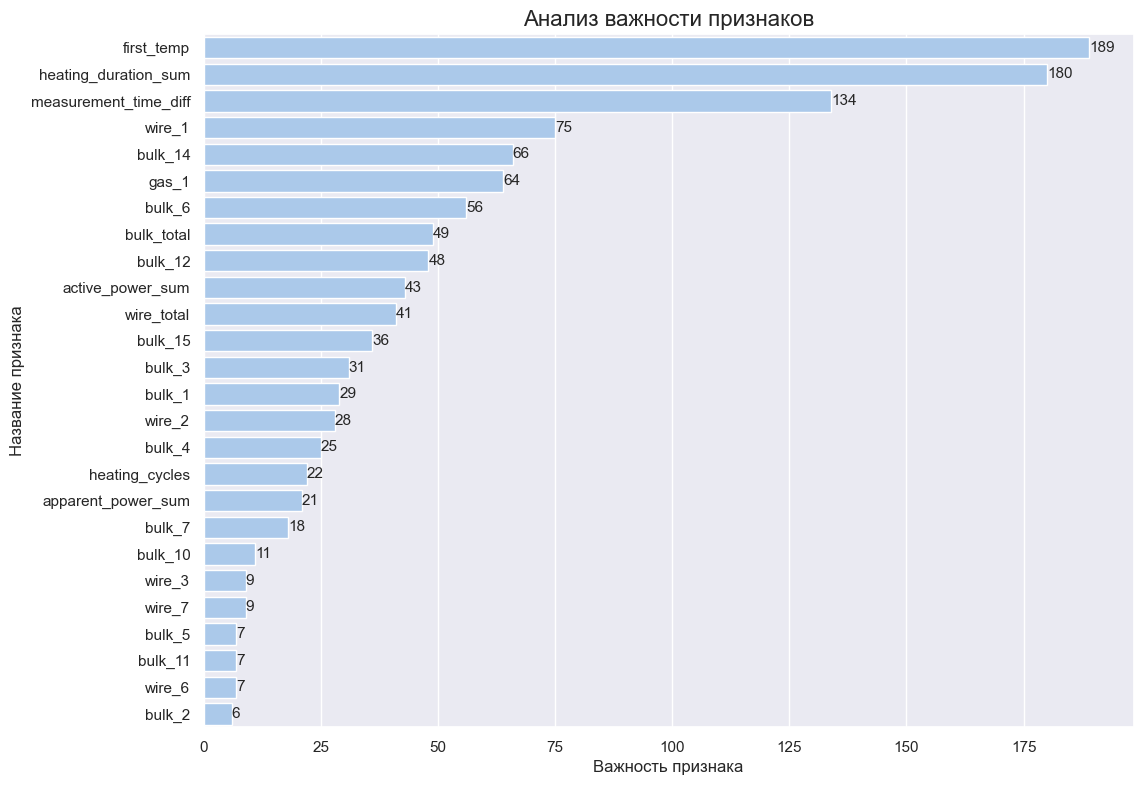

In [156]:
# построим график, отображающий важность признаков 

plt.figure(figsize=(12, 9))
sns.barplot(x='Важность признака', y='Название признака', data=feature_importance_data)
plt.rcParams.update({'font.size': 11})

for index, value in enumerate(feature_importance_data['Важность признака']):
    plt.text(value, index, f'{value:.0f}', va='center')
    
plt.title('Анализ важности признаков', fontsize=16)
plt.show()

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Самыми важными модель сочла суммарное время нагрева, изначальную температуру сплава и разницу между первым и последним замерами температуры. Также на конечную температуру влияют первый цикл подаваемого проволочного материала и объём инертного газа, которым продувают сплав
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Общий вывод
</div>

---

Для решения задачи были предоставлены следующие файлы: `data_arc_new`, `data_bulk_new`, `data_bulk_time_new`, `data_gas_new`, `data_temp_new`, `data_wire_new`, `data_wire_time_new`. В ходе предобработки данных дубликатов обнаружено не было, названия столбцов в каждом файле были приведены к стандарту оформления данных, а типы данных изменены там, где это необходимо. Было выяснено, что в таблицах содержатся данные о 3214 партиях обработки стали. Из файла `data_temp_new`, содержащего целевой признак, были удалены строки с пропусками, составлящие 23% от данных этого столбца. Что касается пропусков в остальных файлах, было принято решение заменить их нулями, не удаляя. 

Для каждой таблицы был отдельно проведён исследовательский анализ. В ходе этого шага было установлено, что активная мощность электродов всегда выше реактивной, что указывает на эффективность использования электроэнергии на комбинате. 

В итоговую таблицу вошли следующие исходные признаки: `gas_1`, `bulk_1`, `bulk_2`, `bulk_3`, `bulk_4`, `bulk_5`, `bulk_6`, `bulk_7`, `bulk_8`, `bulk_9`, `bulk_10`, `bulk_11`, `bulk_12`, `bulk_13`, `bulk_14`, `bulk_15`, `wire_1`, `wire_2`, `wire_3`, `wire_4`, `wire_5`, `wire_6`, `wire_7`, `wire_8` и `wire_9`. В качестве новых признаков была рассчитана работа (`arc_work`), количество циклов нагрева (`heating_cycles`), суммарные объёмы подаваемых сыпучих и проволочных материалов для каждой партии (`bulk_total` и `wire_total`), значение исходной и конечной температур сплава, выраженное в секундах (`first_temp` и `last_temp`), временная разница между первым и последним измерениями температуры, выраженная в секундах (`measurement_time_diff`), суммарные активная, реактивная и полная мощности для каждой партии (`activ_power_sum`, `reactive_power_sum`, `apparent_power_sum`) и суммарное время нагрева для каждой партии (`heating_duration_sum`). После предобработки итоговой таблицы было удалено ещё 5.89% имеющихся в ней данных.

В ходе исследования объединённых данных было выяснено следующее: 

- начальная температура сплава варьируется в диапазоне от 1519 до 1660 градусов и в среднем составляет 1587 градусов. Конечная же температура колеблется между 1541 и 1653 градусами, а среднее значение на 6 градусов выше аналогичного у изначальной температуры и составляет 1593 градуса
- в половине (51%) случаев сплав проходит 4-5 циклов нагрева, чуть реже — в 31% случаев — количество циклов составляет 6 или 3 штуки
- суммарное время нагрева электрода в каждой партии находится в диапазоне от 57 до 4189 секунд (от 1 до 70 минут), а в среднем оно составило 807 секунд (почти 14 минут)
- средний суммарный объём подаваемых сыпучих материалов составил 607, проволочных — 125
- данные содержат информацию об относительно долгих партиях и основными признаками таких партий стали: время между первым и последним замерами температуры, превышающее 5000 секунд; время нагрева, превышающее 2000 секунд; объём подаваемых сыпучих и проволочных материалов, превышающий 1500 и 300 соответственно. Было принято решение оставить данные об этих партиях — всё свидетельствует о том, что это хоть и редкие, но очень значимые для исследования случаи

Корреляционный анализ данных показал, что такие признаки, как `wire_5`, `active_power_sum`, `reactive_power_sum`, `bulk_9`, `wire_8`, `wire_4` создают мультиколлинеарность в данных, поэтому соответствующие столбцы были удалены. Также в ходе этого анализа было выяснено, что объёмы подаваемых сыпучих и проволочных материалов ощутимо зависят друг от друга, как и от данных об объёме каждого цикла подачи материала отдельно. При этом, целевой признак — температура — показал слабую корреляцию со всеми остальными признаками.

---

По условию задачи, нам было необходимо научиться прогнозировать конечную температуру сплава, а это задача регрессии. Ключевой метрикой указана MAE или `Mean Absolute Error`, меньшая или равная 6.8. Так, для обучения были выбраны такие модели, как `Random Forest`, которая, в свою очередь, хорошо справляется с нелинейными зависимостями и взаимодействиями между признаками, `Cat Boost`, устойчивая к переобучению и обладающая встроенными методами обработки пропущенных значений, а также `Gradient Boosting` и `XGBRegressor`. Модели были успешно обучены, и каждая из них отвечает основному требованию по метрике. Данные о результатах обучения (значение метрики и время, затраченное на обучение модели на тренировочной выборке) хранятся в таблице `models`.

Лучшей оказалась модель `XGBRegressor`, имеющая **целевую метрику, равную 5.85** и следующие параметры:

- `colsample_bytree`: 0.7140691999028965
- `learning_rate`: 0.077594906276645
- `min_child_weight`: 2
- `max_depth`: 3
- `n_estimators`: 184
- `subsample`: 0.7687146966865592

Лучшая модель также прошла проверку на адекватность, совершённую с помощью константной модели `Dummy Regressor`:

- `MAE на тестовой выборке для модели XGBRegressor`: 5.850803
- `MAE на тестовой выборке для модели DummyRegressor`: 8.025747

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

В качестве рекомендаций можно предложить бизнесу пересмотреть требования к задаче. Имея информацию о том, какая температура сплава свидетельствует о перегреве, можно превратить задачу регрессии в задачу классификации — **перегрев в партии произошёл** или **не произошёл**. Поставив такую задачу перед специалистами, можно точнее узнать, какие детали и нюансы производства влияют на вероятность перегрева, и, вследствие этого, неэффективного использования электроэнергии. В таком случае модель, имитирующая технологический процесс, предсказывала бы, произойдёт ли перегрев в этой партии, а заказчик бы имел информацию о том, какие факторы этот перегрев точно спровоцируют

</div>